In [5]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as smf
import ipywidgets as widgets
import optuna
import warnings

from scipy.interpolate import CubicSpline
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import TimeSeriesSplit
from statistics import NormalDist
from matplotlib import colors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from dateutil.relativedelta import relativedelta
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import gamma, factorial
from ipywidgets import interact
from scipy.optimize import minimize_scalar, minimize, brute, basinhopping

warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [115]:
!pip install mpl-bsic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [15]:
from mpl_bsic import apply_bsic_style, export_figure, check_figsize

# Importing the data

In [6]:
cpi = pd.read_excel('monthly inflation by currency.xlsx', index_col = 0)
fxspot = pd.read_excel('fx rates.xlsx', index_col = 0)

In [7]:
cpi = cpi[list(cpi.columns.intersection(fxspot.columns))]
fxspot = fxspot[cpi.columns.intersection(fxspot.columns)]

# Class to run Linear PPP regressions on a currency against USD

In [10]:
class linearRegPPP():
    def __init__(self, currency, period_months, train, HAC_lags = None, sigmoid_func = np.tanh, offset_months = 200):
        self.currency = currency
        self.period_months = period_months
        self.train = train
        self.HAC_lags = HAC_lags
        self.sigmoid_func = sigmoid_func
        self.offset_months = offset_months

    def cleandata(self):
        fxspot_clean = fxspot.dropna(subset = [self.currency])      # removes all rows where the target currency has no prices
        merged = pd.merge_asof(cpi, fxspot_clean, on = 'Date', direction = 'nearest', suffixes = ('_cpi', '_fxspot'))  #aligns CPI data and FX
        merged.index = merged['Date']
        merged = merged.drop(['Date'], axis = 1)
        return merged      # this is the data we use for the regressions

    def XY_for_regression(self):
        merged = self.cleandata()
        spot = merged[self.currency + '_fxspot']

        US_infl = merged['USD_cpi']/merged['USD_cpi'].shift(self.period_months)                 # computes USD inflation for the given period
        curr_infl = merged[self.currency + '_cpi']/merged[self.currency + '_cpi'].shift(self.period_months)  # computes target currency inflation for the given period

        US_infl = US_infl * 12/self.period_months
        curr_infl = curr_infl * 12/self.period_months

        Y = np.log(spot/spot.shift(self.period_months))            # computes target currency returns for the given period
        x = US_infl - curr_infl

        mask = Y.notna() | x.notna()                   # makes sure we only pick the rows where no NaNs are present
        Y = Y[mask]
        x = x[mask]
        return x, Y

    def split_test_train(self):                        # coded this myself dunno if I should use a prebuilt one
        x, Y = self.XY_for_regression()
        Y_train = Y[:int(np.floor(len(Y)*self.train))]
        x_train = x[:int(np.floor(len(x)*self.train))]

        Y_test = Y[int(np.floor(len(Y)*self.train)) + 1:]
        x_test = x[int(np.floor(len(x)*self.train)) + 1:]

        return x_train, Y_train, x_test, Y_test

    def fxspot(self):
        dataset = fxspot.dropna(subset = [self.currency])
        spot = dataset[self.currency]
        spot_train = spot[:int(np.floor(len(spot)*self.train))]
        spot_test = spot[int(np.floor(len(spot)*self.train)) + 1:]

        return spot_train, spot_test

    def offset_days_count(self):
        x_all, _ = self.XY_for_regression()
        spot_daily = fxspot[self.currency].dropna()
        y_daily = np.log(spot_daily / spot_daily.shift(self.period_months * 30))

        # Find the exact date where the offset_months cutoff lands
        offset_date = x_all.dropna().index[self.offset_months]

        # Count how many daily y values are strictly before this cutoff
        skipped_days = y_daily.index[y_daily.index < offset_date]
        return len(skipped_days)

    def expanding_window_dislocations(self):
        x_all, y_all = self.XY_for_regression()

        spot_daily = fxspot[self.currency].dropna()
        y_daily = np.log(spot_daily / spot_daily.shift(self.period_months * 30))

        start_date = x_all.dropna().index[self.offset_months]

        monthly_dates = pd.date_range(start=start_date, end=x_all.index[-1], freq='M')

        preds = pd.Series(index=y_daily.index, dtype=float)

        for month_end in monthly_dates:

            x_window = x_all[:month_end]
            y_window = y_all[:month_end]

            # Skip if not enough data
            if len(x_window.dropna()) < 5:
                print('x_window shorter than 5')
                continue

            try:
                df = pd.DataFrame({'Y': y_window, 'X': x_window}).dropna()
                model = smf.OLS(df['Y'], smf.add_constant(df['X'])).fit(cov_type='HAC', cov_kwds={'maxlags': self.HAC_lags})

                # Predict next month's return using last X value
                x_next_month = x_all.loc[month_end:].iloc[0]  # first available after month_end
                x_pred = pd.DataFrame({'X': [x_next_month]})
                x_pred = smf.add_constant(x_pred, has_constant='add')

                y_pred_monthly = model.predict(x_pred).iloc[0]

                # Daily range for next month
                next_month_start = month_end + pd.Timedelta(days=1)
                next_month_end = (next_month_start + pd.offsets.MonthEnd(1))


                preds.loc[next_month_start:next_month_end] = y_pred_monthly

            except Exception as e:
                print(f"Skipping {month_end.date()} due to error: {e}")
                continue

        aligned_preds = preds.reindex(y_daily.index, method='ffill')
        dislocations = y_daily - aligned_preds
        transformed_dislocations = self.sigmoid_func(dislocations) - self.sigmoid_func(dislocations).expanding().mean()

        full_dict = {'y_daily':y_daily,
                       'aligned_preds':aligned_preds,
                       'dislocations':dislocations,
                       'transformed_dislocations':transformed_dislocations,
                    'spot':spot_daily}

        split_point = int(len(y_daily) * self.train)

        train_dict = {'y_daily':y_daily.iloc[:split_point],
                       'aligned_preds':aligned_preds.iloc[:split_point],
                       'dislocations':dislocations.iloc[:split_point],
                       'transformed_dislocations':transformed_dislocations.iloc[:split_point],
                     'spot':spot_daily.iloc[:split_point]}

        test_dict = {'y_daily':y_daily.iloc[split_point:],
                       'aligned_preds':aligned_preds.iloc[split_point:],
                       'dislocations':dislocations.iloc[split_point:],
                       'transformed_dislocations':transformed_dislocations.iloc[split_point:],
                     'spot':spot_daily.iloc[split_point:]}

        return full_dict, train_dict, test_dict

    def plot_deviations(self):
        # Get the dislocations using the expanding window approach
        _, train_dict, test_dict = self.expanding_window_dislocations()

        # Get and transform
        train_devs_daily = self.sigmoid_func(train_dict['dislocations'])
        test_devs_daily = self.sigmoid_func(test_dict['dislocations'])

        # Plot
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

        ax[0].plot(train_devs_daily - train_devs_daily.mean(), color='black')
        ax[0].set_title('Train Set (Demeaned Deviations)')

        ax[1].plot(test_devs_daily - test_devs_daily.mean(), color='black')
        ax[1].set_title('Test Set (Demeaned Deviations)')

        fig.suptitle(f'Demeaned Sigmoid Deviations for Currency: {self.currency}', fontsize=14)
        plt.tight_layout()
        plt.show()


    def plot_dislocations(self):
        # Use test set dislocations from expanding window
        dislocation = self.expanding_window_dislocations()[2]['dislocations']

        std = dislocation.std()
        upper_band = std
        lower_band = -std

        active_signal = None
        signals = []

        for i in range(1, len(dislocation)):
            val = dislocation.iloc[i]
            prev_val = dislocation.iloc[i - 1]

            if active_signal is None:
                if val > upper_band and prev_val <= upper_band:
                    signals.append((dislocation.index[i], val, 'short'))
                    active_signal = 'short'
                elif val < lower_band and prev_val >= lower_band:
                    signals.append((dislocation.index[i], val, 'long'))
                    active_signal = 'long'
            else:
                if prev_val < 0 and val >= 0 and active_signal == 'long':
                    active_signal = None
                elif prev_val > 0 and val <= 0 and active_signal == 'short':
                    active_signal = None

        # Plot
        plt.figure(figsize=(14, 5))
        plt.plot(dislocation, label='Dislocation (Actual[t+1] - Predicted[t])', color='purple')
        plt.axhline(0, color='red', linestyle='-', linewidth=2, label='Mean (0 line)')
        plt.axhline(upper_band, color='blue', linestyle='--', linewidth=1.5, label='+1 SD')
        plt.axhline(lower_band, color='blue', linestyle='--', linewidth=1.5, label='-1 SD')

        for date, value, direction in signals:
            if direction == 'short':
                plt.scatter(date, value, marker='v', s=100, color='red', label='_nolegend_')
            else:
                plt.scatter(date, value, marker='^', s=100, color='green', label='_nolegend_')

        plt.legend(title=f'Number of trades: {len(signals)}')
        plt.title(f'Shifted Prediction Dislocations for {self.currency}')
        plt.xlabel('Date')
        plt.ylabel('Dislocation')
        plt.tight_layout()
        plt.show()

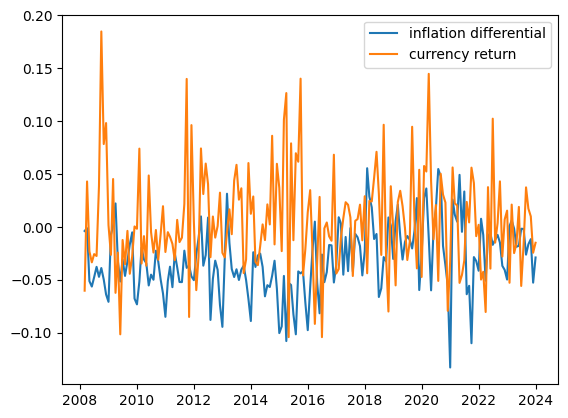

In [7]:
a = linearRegPPP(currency = 'BRL', period_months = 1, offset_months=50, train = 0.5)
plt.plot(a.XY_for_regression()[0], label = 'inflation differential')
plt.plot(a.XY_for_regression()[1], label = 'currency return')
plt.legend()

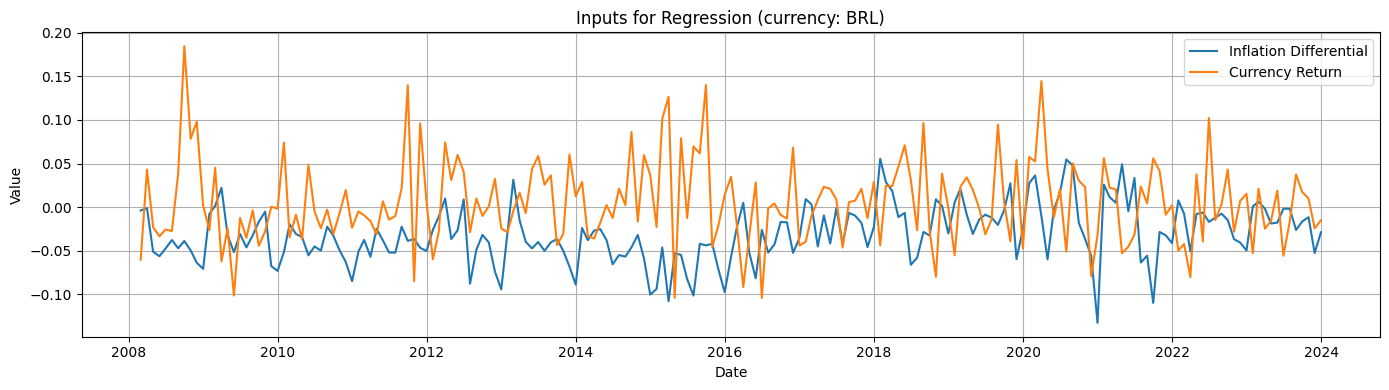

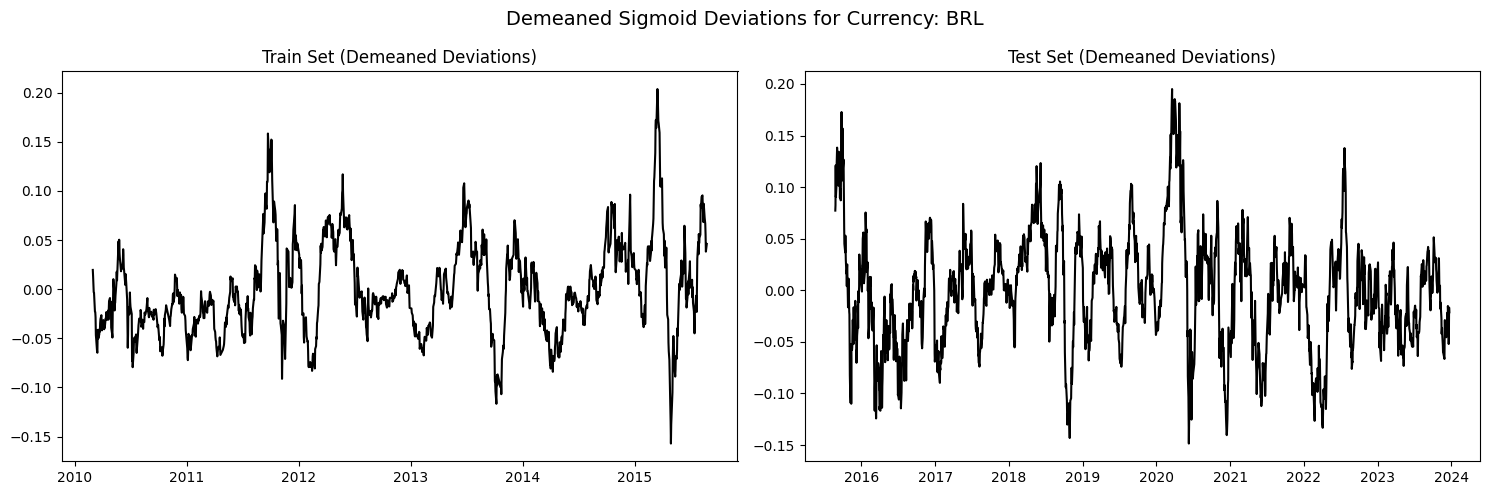

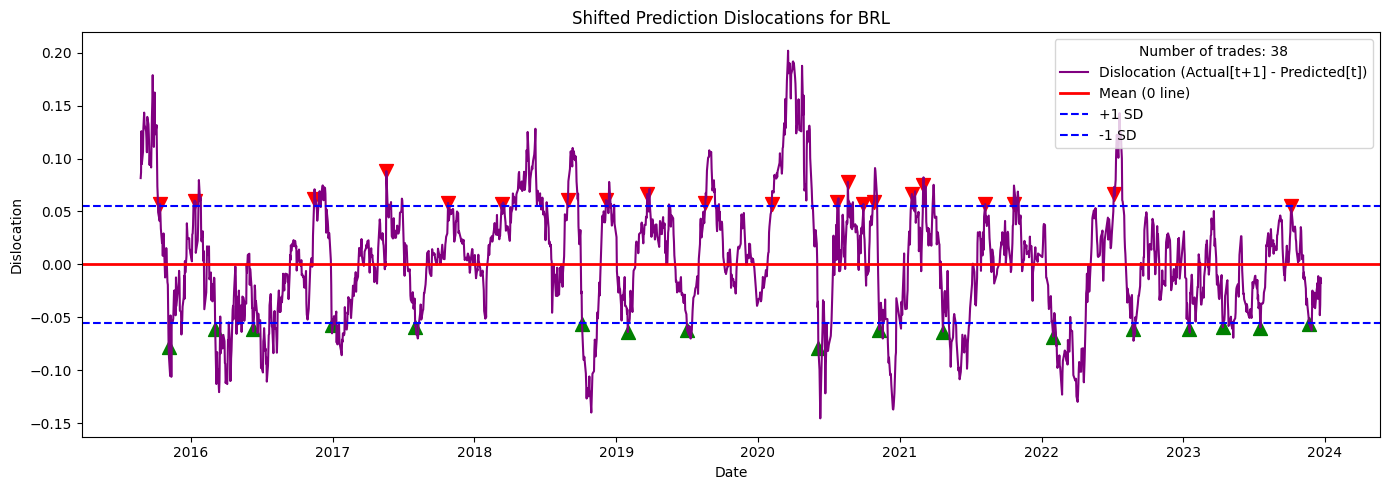

In [8]:
a = linearRegPPP(currency='BRL', period_months=1, train=0.5, offset_months=24)

# Step 2: Plot XY_for_regression outputs
x, Y = a.XY_for_regression()
plt.figure(figsize=(14, 4))
plt.plot(x, label='Inflation Differential')
plt.plot(Y, label='Currency Return')
plt.legend()
plt.title(f'Inputs for Regression (currency: {a.currency})')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 3: Plot deviations from training/test sets
a.plot_deviations()

# Step 4: Plot dislocations and trading signals (test set only)
a.plot_dislocations()

# Backtester class

#### Note from Ric
We set up the backtester to have customizable exit points. If we decide it's useless, we just set up exit points to 0 SD when calling an instance of the backtest class.

In [11]:
class Backtest():

    def __init__(self, series, fxspot_series, long_entry, long_exit,
                 short_entry, short_exit, currency_name, offset,
                 transaction_costs, sdApply=True, stop_loss=None):
        self.series = series
        self.fxspot_series = fxspot_series
        self.long_entry = long_entry
        self.long_exit = long_exit
        self.short_entry = short_entry
        self.short_exit = short_exit
        self.currency_name = currency_name
        self.offset = offset
        self.sdApply = sdApply
        self.transaction_costs = transaction_costs
        self.stop_loss = stop_loss

    def determine_position(self):
        signals = [0] * self.offset
        expanding_sd = [np.nan] * self.offset
        long_entry_series = [np.nan] * self.offset
        long_exit_series = [np.nan] * self.offset
        short_entry_series = [np.nan] * self.offset
        short_exit_series = [np.nan] * self.offset

        entry_price = None

        for t in range(self.offset, len(self.series)):
            std_unit = self.series.iloc[:t].std()
            expanding_sd.append(std_unit)

            long_entry = self.long_entry * std_unit if self.sdApply else self.long_entry
            long_exit = self.long_exit * std_unit if self.sdApply else self.long_exit
            short_entry = self.short_entry * std_unit if self.sdApply else self.short_entry
            short_exit = self.short_exit * std_unit if self.sdApply else self.short_exit

            long_entry_series.append(long_entry)
            long_exit_series.append(long_exit)
            short_entry_series.append(short_entry)
            short_exit_series.append(short_exit)

            #signal = signals[-1]
            signal = signals[-1] if len(signals) > 0 else 0
            price = self.fxspot_series.iloc[t]

            if signal != 0 and entry_price is not None and self.stop_loss is not None:
                drawdown = (price - entry_price) / entry_price if signal == -1 else (entry_price - price) / entry_price
                if drawdown > self.stop_loss:
                    signals.append(0)
                    entry_price = None
                    continue

            if self.series.iloc[t] <= long_exit:
                if self.series.iloc[t] <= long_entry:
                    signals.append(1)
                    entry_price = price if signal != 1 else entry_price
                else:
                    signals.append(1 if signal == 1 else 0)
            elif self.series.iloc[t] >= short_exit:
                if self.series.iloc[t] >= short_entry:
                    signals.append(-1)
                    entry_price = price if signal != -1 else entry_price
                else:
                    signals.append(-1 if signal == -1 else 0)
            else:
                signals.append(0)

        return {
            'signals': pd.Series(signals, index=self.series.index),
            'SD': pd.Series(expanding_sd, index=self.series.index),
            'bands': [
                pd.Series(long_entry_series, index=self.series.index),
                pd.Series(long_exit_series, index=self.series.index),
                pd.Series(short_entry_series, index=self.series.index),
                pd.Series(short_exit_series, index=self.series.index),
            ]
        }

    def profitandloss(self):
        results = self.determine_position()
        signals = results['signals']
        fxspot = 1 / self.fxspot_series
        index = signals.index.intersection(fxspot.index)

        fx_returns = fxspot.pct_change().fillna(0)

        pnl = signals * fx_returns
        buysell = signals.loc[index].diff().fillna(0)

        buysell.iloc[-1] = buysell.iloc[-2]
        number_of_trades = np.cumsum(abs(buysell))
        tr_cost_balance = number_of_trades * self.transaction_costs

        cumpnl = pnl.cumsum() - tr_cost_balance
        bh_cumpnl = fx_returns.cumsum()

        # ADD THIS: Compute annualized return
        min_days = 90
        time_passed_cumpnl = (cumpnl.index - cumpnl.index[0]).days / 365
        time_passed_bh = (bh_cumpnl.index - bh_cumpnl.index[0]).days / 365
        time_passed_cumpnl = time_passed_cumpnl.where(time_passed_cumpnl > min_days / 365)
        time_passed_bh = time_passed_bh.where(time_passed_bh > min_days / 365)

        cumreturns = ((1 + cumpnl)**(1 / time_passed_cumpnl) - 1) * 100
        bh_cumreturns = ((1 + bh_cumpnl)**(1 / time_passed_bh) - 1) * 100

        df = pd.DataFrame({
            'buysell': buysell,
            'number_of_trades': number_of_trades,
            'pnl': pnl,
            'cumpnl': cumpnl,
            'buyhold': bh_cumpnl,
            'cumreturns': cumreturns,
            'bh_cumreturns': bh_cumreturns
        }).dropna()

        first_trade_idx = df['pnl'].ne(0).idxmax()
        return df.loc[first_trade_idx:]

    def plot_entry_points(self):
        from mpl_bsic import apply_bsic_style, export_figure

        results = self.determine_position()
        signals = results['signals']
        long_entry, long_exit, short_entry, short_exit = results['bands']

        first_trade_idx = signals.ne(0).idxmax()

        signals = signals.loc[first_trade_idx:]
        long_entry = long_entry.loc[first_trade_idx:]
        long_exit = long_exit.loc[first_trade_idx:]
        short_entry = short_entry.loc[first_trade_idx:]
        short_exit = short_exit.loc[first_trade_idx:]
        signal_series = self.series.loc[first_trade_idx:]
        spot_series = self.fxspot_series.loc[first_trade_idx:]

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), constrained_layout=True)

        entry_band_color = "purple"
        exit_band_color = "lightblue"

        # Left plot: signal
        ax[0].plot(signal_series, label='Signal', color='navy')
        ax[0].plot(short_entry, color=entry_band_color, label='Entry Levels')
        ax[0].plot(long_entry, color=entry_band_color)
        ax[0].plot(short_exit, color=exit_band_color, linestyle='--', label='Exit Levels')
        ax[0].plot(long_exit, color=exit_band_color, linestyle='--')

        # Green up arrows for long entries
        ax[0].plot(
            signal_series.where((signals.diff() == 1) & (signal_series <= long_entry)),
            marker='^',
            markersize=6,
            color='green',
            markerfacecolor='green',
            markeredgecolor='green',
            linestyle='None',
            label='Long Entries'
        )

        # Red down arrows for short entries
        ax[0].plot(
            signal_series.where((signals.diff() == -1) & (signal_series >= short_entry)),
            marker='v',
            markersize=6,
            color='red',
            markerfacecolor='red',
            markeredgecolor='red',
            linestyle='None',
            label='Short Entries'
        )

        ax[0].legend()
        ax[0].set_title('Signal and Entry Points')
        ax[0].set_xlabel('Date')
        ax[0].set_ylabel('Dislocation')

        # Right plot: spot price
        ax[1].plot(spot_series, color='navy', label=f'USD/{self.currency_name}')

        ax[1].plot(
            spot_series.where((signals.diff() == 1) & (signal_series <= long_entry)),
            marker='^',
            markersize=6,
            color='green',
            markerfacecolor='green',
            markeredgecolor='green',
            linestyle='None',
            label='Long Entries'
        )

        ax[1].plot(
            spot_series.where((signals.diff() == -1) & (signal_series >= short_entry)),
            marker='v',
            markersize=6,
            color='red',
            markerfacecolor='red',
            markeredgecolor='red',
            linestyle='None',
            label='Short Entries'
        )

        ax[1].legend()
        ax[1].set_title('FX Spot Price with Trade Entries')
        ax[1].set_xlabel('Date')
        ax[1].set_ylabel('FX Spot Price')
        fig.suptitle(f"{self.currency_name} Optimized Strategy")

        apply_bsic_style(fig, ax[0])
        apply_bsic_style(fig, ax[1])

        export_figure(fig, f"entry_points_{self.currency_name}")
        plt.show()

    def performance_metrics(self, start_date=None):
        df = self.profitandloss()
        if start_date:
            df = df[df.index >= pd.to_datetime(start_date)]

        daily_returns = df['pnl']
        bh_returns = df['buyhold'].diff()

        def metrics(returns, ref_series):
            ann_factor = 252
            non_zero_returns = returns[returns != 0]
            sharpe = returns.mean() / returns.std() * np.sqrt(ann_factor)
            downside = returns[returns < 0]
            sortino = returns.mean() / downside.std() * np.sqrt(ann_factor) if len(downside) > 0 else np.nan
            skew = non_zero_returns[non_zero_returns > 0].mean() / abs(non_zero_returns[non_zero_returns < 0].mean()) if len(non_zero_returns[non_zero_returns < 0]) > 0 else np.nan
            hit_ratio = (non_zero_returns > 0).sum() / len(non_zero_returns) if len(non_zero_returns) > 0 else np.nan
            ann_vol = returns.std() * np.sqrt(ann_factor)

            roll_max = ref_series.cummax()
            dd = (roll_max - ref_series)
            max_dd = dd.max()

            return {
                'Sharpe Ratio': sharpe,
                'Sortino Ratio': sortino,
                'Skew': skew,
                'Hit Ratio': hit_ratio,
                'Annualized Volatility': ann_vol,
                'Max Drawdown': max_dd
            }

        return {
            'Strategy': metrics(daily_returns, df['cumpnl']),
            'Buy and Hold': metrics(bh_returns.dropna(), df['buyhold'])
        }

    def display_performance_table(self, start_date=None):
        metrics = self.performance_metrics(start_date=start_date)
        metrics_df = pd.DataFrame(metrics).T.round(4)
        print(f"Performance Metrics for {self.currency_name} Strategy vs Buy-and-Hold:\n")
        print(metrics_df.to_string())

# Backtests on NZD

adding fonts to font manager
base dir:  /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mpl_bsic
fonts dir:  /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mpl_bsic/fonts
fonts already added so will not add again


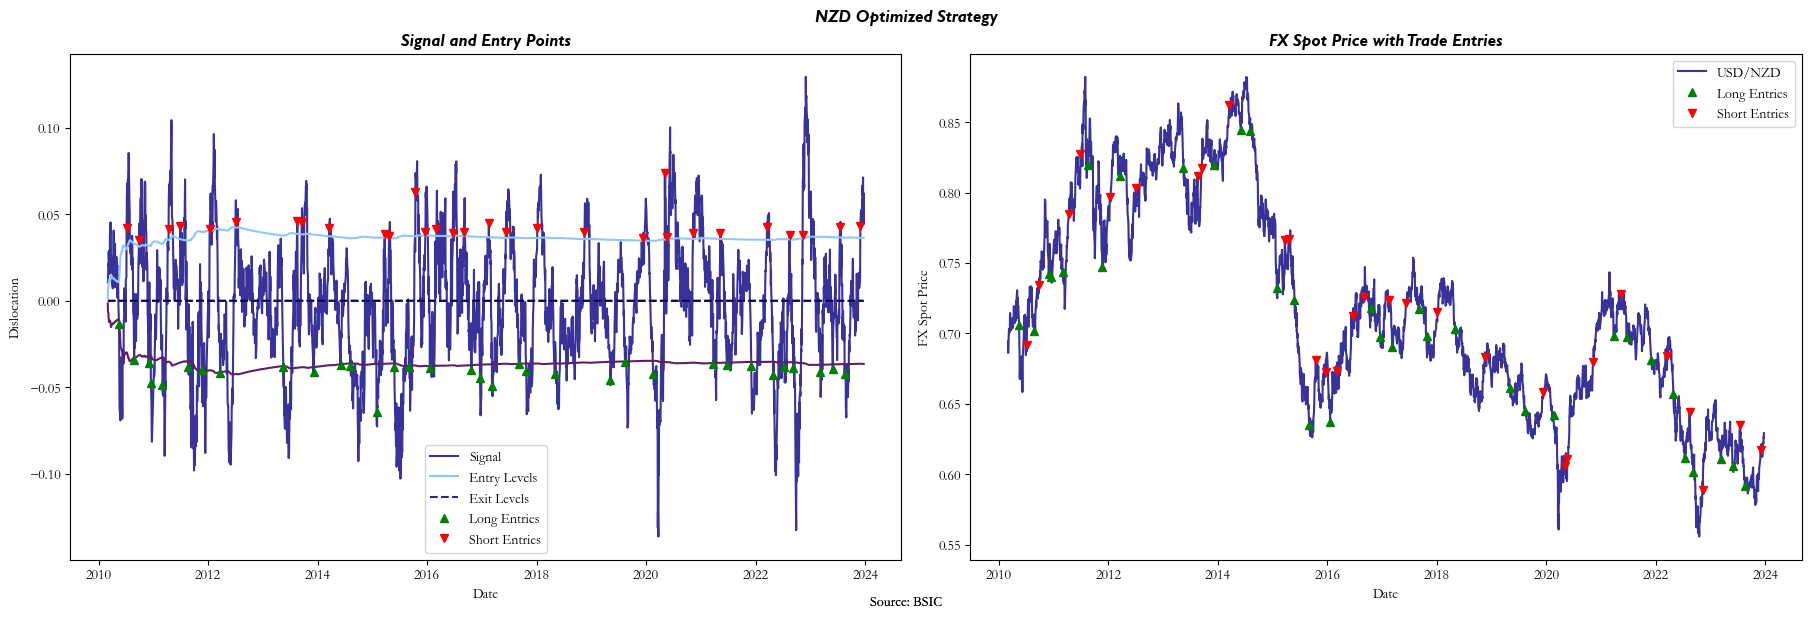

In [12]:
ccy = 'NZD'

a = linearRegPPP(
    currency=ccy,
    period_months=1,
    HAC_lags=0,
    offset_months=24,
    train=0.5
)

full_dict, train_dict, test_dict = a.expanding_window_dislocations()

bt = Backtest(
    series=full_dict['transformed_dislocations'],
    fxspot_series=full_dict['spot'],
    long_entry=-1,
    long_exit=0,
    short_entry=1,
    short_exit=0,
    currency_name=ccy,
    offset=24,
    transaction_costs=0.002,
    stop_loss=1000
)

bt.plot_entry_points()

fonts already added so will not add again


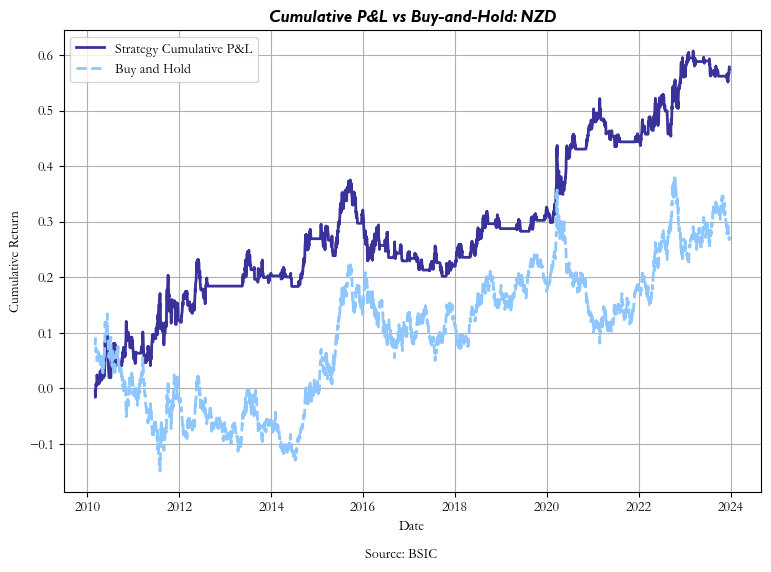

Performance Metrics for NZD Strategy vs Buy-and-Hold:

              Sharpe Ratio  Sortino Ratio    Skew  Hit Ratio  Annualized Volatility  Max Drawdown
Strategy            0.6896         0.8147  0.9984     0.5387                 0.0930        0.1734
Buy and Hold        0.1231         0.1973  1.0114     0.5023                 0.1174        0.2828


In [16]:
pnl = bt.profitandloss()

fig, ax = plt.subplots(figsize=(9, 6))  # BSIC size
ax.plot(pnl['cumpnl'], label='Strategy Cumulative P&L', linewidth=2)
ax.plot(pnl['buyhold'], label='Buy and Hold', linestyle='--', color='gray', linewidth=2)

ax.set_title(f'Cumulative P&L vs Buy-and-Hold: {bt.currency_name}')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.grid(True)
ax.legend()

apply_bsic_style(fig, ax)

export_figure(fig, f"pnl_vs_bh_{bt.currency_name}")

plt.show()

bt.display_performance_table()

In [8]:
class EoS_calibrated():

    def __init__(self, currency, period_months, train, regression_offset_months,
                 HAC_lags = None, sigmoid_func = np.tanh, N_cap = 101,
                 OLS_dt = 1, transaction_costs = 0, test_set_offset_days = 120):
        self.currency = currency
        self.period_months = period_months
        self.train = train
        self.HAC_lags = HAC_lags
        self.sigmoid_func = sigmoid_func
        self.regression_offset_months = regression_offset_months
        self.OLS_dt = OLS_dt
        self.transaction_costs = transaction_costs
        self.test_set_offset_days = test_set_offset_days
        self.N_cap = N_cap

    def dislocations(self):
        a = linearRegPPP(currency = self.currency, period_months = self.period_months, train = self.train,
                         HAC_lags = self.HAC_lags, sigmoid_func = self.sigmoid_func,
                         offset_months = self.regression_offset_months)

        full_dict = a.expanding_window_dislocations()[0]
        train_dict = a.expanding_window_dislocations()[1]
        test_dict = a.expanding_window_dislocations()[2]
        offset_days = a.offset_days_count()

        return {'full':full_dict, 'train':train_dict, 'test':test_dict, 'offset_days': offset_days}

    def endofsample_OLS_params(self):

        regOutput = self.dislocations()
        full_dict = regOutput['full']
        train_dict = regOutput['train']
        test_dict = regOutput['test']
        offset_days = regOutput['offset_days']

        dislocations_train = train_dict['transformed_dislocations']
        dislocations_test = test_dict['transformed_dislocations']
        dislocations_full = full_dict['transformed_dislocations']

        fxspot_train = train_dict['spot']
        fxspot_test = test_dict['spot']

        df = expanding_OU_from_dislocation(dislocations_train, min_window= offset_days, dt=self.OLS_dt)
        kappa = df['kappa']
        theta = df['theta']
        sigma = df['sigma']

        return {'kappa':kappa[-1], 'theta': theta[-1], 'sigma': sigma[-1]}

    def equationSolver(self):
        def lhs(x, N_iter = self.N_cap):
            total = 0.0
            for k in range(N_iter):
                term = gamma((2 * k + 1) / 2) * ((np.sqrt(2) * x) ** (2 * k + 1)) / factorial(2 * k + 1)
                total += term
            return 1/2 * total

        def rhs(x, N_iter = self.N_cap,c=0):
            total = 0.0
            for k in range(N_iter):
                term = gamma((2*k + 1) / 2) * ((np.sqrt(2) * x) ** (2 * k)) / factorial(2 * k)
                total += term
            return (x-c/2) * np.sqrt(2)/2 * total

        def make_objective(c):
            def objective(x):
                return (lhs(x) - rhs(x, c=c))**2
            return objective

        result = lambda c: minimize_scalar(make_objective(c), bounds=(1e-6, 5.0), method='bounded').success
        return result(self.transaction_costs)

    def optimal_entry_exit(self):
        OLS_params = self.endofsample_OLS_params()
        theta = OLS_params['kappa']
        mu = OLS_params['theta']
        sigma = OLS_params['sigma']
        return {'short_entry':self.equationSolver() * (sigma/(np.sqrt(2 * theta))) + mu,
                'long_entry': (-1) * self.equationSolver() * (sigma/(np.sqrt(2*theta))) + mu}

    def Backtest_paper(self):
        regOutput = self.dislocations()
        full_dict = regOutput['full']
        train_dict = regOutput['train']
        test_dict = regOutput['test']
        offset_days = regOutput['offset_days']

        dislocations_train = train_dict['transformed_dislocations']
        dislocations_test = test_dict['transformed_dislocations']
        dislocations_full = full_dict['transformed_dislocations']

        fxspot_train = train_dict['spot']
        fxspot_test = test_dict['spot']

        optimal_short, optimal_long = self.optimal_entry_exit()['short_entry'], self.optimal_entry_exit()['long_entry']

        train_backtest_paper = Backtest(series = dislocations_train, fxspot_series = fxspot_train,
                          long_entry = optimal_long, long_exit = optimal_short - 0.001,
                          short_entry = optimal_short, short_exit = optimal_long + 0.001,
                          currency_name = self.currency, offset = offset_days, transaction_costs= self.transaction_costs,
                                        sdApply = False)

        test_backtest_paper = Backtest(series = dislocations_test, fxspot_series = fxspot_test,
                          long_entry = optimal_long, long_exit = optimal_short - 0.001,
                          short_entry = optimal_short, short_exit = optimal_long + 0.001,
                         currency_name = self.currency, offset = 1, transaction_costs= self.transaction_costs,
                                       sdApply = False)

        return train_backtest_paper, test_backtest_paper

    def paper_sharpe(self):
        train_backtest, test_backtest = self.Backtest_paper()
        train_sharpe = train_backtest['cumreturns'].mean()/train_backtest['cumreturns'].std()
        test_sharpe = test_backtest['cumreturns'].mean()/test_backtest['cumreturns'].std()
        return {'train_sharpe':train_sharpe, 'test_sharpe':test_sharpe}

    def numericalOptima(self):
        regOutput = self.dislocations()
        full_dict = regOutput['full']
        train_dict = regOutput['train']
        test_dict = regOutput['test']
        offset_days = regOutput['offset_days']

        dislocations_train = train_dict['transformed_dislocations']
        dislocations_test = test_dict['transformed_dislocations']
        dislocations_full = full_dict['transformed_dislocations']

        fxspot_train = train_dict['spot']
        fxspot_test = test_dict['spot']

        def profit_target(path, fxspot, currency, L_entry, L_exit, S_entry, S_exit):      # we can't give this directly to Optuna
            backtest = Backtest(series = path, fxspot_series = fxspot,
                                long_entry = L_entry, long_exit = L_exit,
                                short_entry = S_entry, short_exit = S_exit,
                                currency_name = currency, offset = 0, transaction_costs= self.transaction_costs)
            return (-1) * backtest.profitandloss()['cumpnl'][-1]
                                                                                        # so we create an optuna optimizer based on it
        def optimizer_objective(trial, path, fxspot, currency):
            L_entry = trial.suggest_float("L_entry", -3, 0)
            L_exit = trial.suggest_float("L_exit", L_entry, 0)

            S_entry = trial.suggest_float("S_entry", 0, 3)
            S_exit = trial.suggest_float("S_exit", 0, S_entry)

            if abs(L_entry) < abs(L_exit) or abs(S_entry) < abs(S_exit):
                raise optuna.exceptions.TrialPruned()

            pnl = profit_target(path, fxspot, currency, L_entry, L_exit, S_entry, S_exit)
            return pnl

        def Optuna(path, fxspot, currency, N_trials):
            study = optuna.create_study()
            study.optimize(lambda trial: optimizer_objective(trial, path, fxspot, currency), n_trials = N_trials)
            return study.best_params

        def Combined(path, fxspot, currency, N_global_trials, N_local_trials):
            optunaguess = Optuna(path, fxspot, currency, N_global_trials)
            params_guess = list(optunaguess.values())

            constraints = [{'type': 'ineq', 'fun': lambda P: -P[0]},           # P1 < 0 → -P1 ≥ 0
                           {'type': 'ineq', 'fun': lambda P: P[1] - P[0]},     # P2 > P1 → P2 - P1 ≥ 0
                           {'type': 'ineq', 'fun': lambda P: -P[1]},           # P2 < 0 → -P2 ≥ 0
                           {'type': 'ineq', 'fun': lambda P: P[2]},            # P3 > 0
                           {'type': 'ineq', 'fun': lambda P: P[2] - P[3]},     # P4 < P3 → P3 - P4 ≥ 0
                           {'type': 'ineq', 'fun': lambda P: P[3]}             # P4 > 0
                          ]
            tgt_fun = lambda param: profit_target(path, fxspot, currency, param[0], param[1], param[2], param[3])
            localopt = (minimize(tgt_fun, params_guess, method = 'SLSQP', constraints=constraints,
                                 options={'disp': True, 'maxiter': N_local_trials}).x)
            if abs(tgt_fun(params_guess)) > abs(tgt_fun(localopt)):
                return params_guess
            else:
                return localopt

        optimal_params = Combined(dislocations_train, fxspot_train, self.currency, N_global_trials = 1000, N_local_trials = 200)
        return optimal_params # which will be in the format L_entry, L_exit, S_entry, S_exit

    def Backtest_numerical(self):
        regOutput = self.dislocations()
        full_dict = regOutput['full']
        train_dict = regOutput['train']
        test_dict = regOutput['test']
        offset_days = regOutput['offset_days']

        dislocations_train = train_dict['transformed_dislocations']
        dislocations_test = test_dict['transformed_dislocations']
        dislocations_full = full_dict['transformed_dislocations']

        fxspot_train = train_dict['spot']
        fxspot_test = test_dict['spot']

        optimal_points = self.numericalOptima()

        optimal_long_entry = optimal_points[0]
        optimal_long_exit = optimal_points[1]
        optimal_short_entry = optimal_points[2]
        optimal_short_exit = optimal_points[3]

        train_backtest_numerical = Backtest(series = dislocations_train, fxspot_series = fxspot_train,
                          long_entry = optimal_long_entry, long_exit = optimal_long_exit,
                          short_entry = optimal_short_entry, short_exit = optimal_short_exit,
                          currency_name = self.currency, offset = offset_days, sdApply = True, transaction_costs= self.transaction_costs)

        test_backtest_numerical = Backtest(series = dislocations_test, fxspot_series = fxspot_test,
                          long_entry = optimal_long_entry, long_exit = optimal_long_exit,
                          short_entry = optimal_short_entry, short_exit = optimal_short_exit,
                         currency_name = self.currency, offset = 1, sdApply = True, transaction_costs= self.transaction_costs)

        return train_backtest_numerical, test_backtest_numerical

# OLS estimator of Ornstein-Uhlenbeck parameters

In [18]:
def expanding_OU_from_dislocation(dislocation_series, min_window=30, dt=1/365):
    results = []
    dislocation_df = pd.DataFrame({'dislocation': dislocation_series.dropna()})

    for end_date in dislocation_df.index[min_window:]:
        window = dislocation_df.loc[:end_date]
        X_lag = window['dislocation'].shift(1).dropna()
        Y_curr = window['dislocation'].loc[X_lag.index]

        if len(X_lag) < 2:
            continue

        model = smf.OLS(Y_curr, smf.add_constant(X_lag)).fit()

        try:
            alpha = model.params['dislocation']
            beta = model.params['const']
        except KeyError:
            continue  # Skip if keys are missing

        residual_var = np.var(model.resid, ddof=1)

        if alpha > 0:
            kappa = -np.log(alpha) / dt
            theta = beta / (1 - alpha)
            sigma = np.sqrt(2 * kappa * residual_var / (1 - alpha**2))
        else:
            kappa, theta, sigma = np.nan, np.nan, np.nan

        results.append({
            'Date': end_date,
            'kappa': kappa,
            'theta': theta,
            'sigma': sigma
        })

    return pd.DataFrame(results).set_index('Date')

# Ultimate class to run optimized backtests for a given currency

### Notes from Ric

the class EoS_calibrated essentially runs two types of backtests for a currency, calibrating optimal/entry exit points at the end of the train sample:
1. A backtest using the optimal entry/exit points that the paper's methodology defined, based on all the data in the train sample, via Backtest_paper().
2. A backtest using the optimal entry/exit points that the numerical optimizer derives, based on all the data in the train sample, via Backtest_numerical().


__DISCLAIMER__: I know that running a backtest on the train sample with entry/exit points that were calibrated at the end of the train sample makes no sense. It's just something I did as a debugging check, to make sure that the class was computing entries/exits that made sense.


Approach (1) relies on OU-fitted parameters computed via OLS, which the class feeds to Alessandro's equation solver to determine optimal bands as shown in the paper underlying the Hudson article. Approach (2) takes the actual series of train set dislocations, and attempts different values of Long/Short Entry/Exit bands. More formally:
* It takes train set dislocations and finds a global maximiser via Optuna
* It takes the global maximiser suggested by Optuna and feeds it to scipy.minimize (a local optimizer) which returns a locally-minimized set of parameters.
* __Why do this two-step procedure?__ It's just a safety provision in case the iterations we let the optuna optimizer do are not enough and it finds something that is very close to a global optimizer, but not exactly the global optimizer. Also, running a local optimizer (such as scipy.minimize) is very risky because it's sensitive to an initial guess. How do we make that guess? With a global optimizer like optuna!



In [19]:
class EoS_calibrated():

    def __init__(self, currency, period_months, train, regression_offset_months,
                 HAC_lags = None, sigmoid_func = np.tanh, N_cap = 101,
                 OLS_dt = 1, transaction_costs = 0, test_set_offset_days = 120):
        self.currency = currency
        self.period_months = period_months
        self.train = train
        self.HAC_lags = HAC_lags
        self.sigmoid_func = sigmoid_func
        self.regression_offset_months = regression_offset_months
        self.OLS_dt = OLS_dt
        self.transaction_costs = transaction_costs
        self.test_set_offset_days = test_set_offset_days
        self.N_cap = N_cap

    def dislocations(self):
        a = linearRegPPP(currency = self.currency, period_months = self.period_months, train = self.train,
                         HAC_lags = self.HAC_lags, sigmoid_func = self.sigmoid_func,
                         offset_months = self.regression_offset_months)

        full_dict = a.expanding_window_dislocations()[0]
        train_dict = a.expanding_window_dislocations()[1]
        test_dict = a.expanding_window_dislocations()[2]
        offset_days = a.offset_days_count()

        return {'full':full_dict, 'train':train_dict, 'test':test_dict, 'offset_days': offset_days}

    def endofsample_OLS_params(self):

        regOutput = self.dislocations()
        full_dict = regOutput['full']
        train_dict = regOutput['train']
        test_dict = regOutput['test']
        offset_days = regOutput['offset_days']

        dislocations_train = train_dict['transformed_dislocations']
        dislocations_test = test_dict['transformed_dislocations']
        dislocations_full = full_dict['transformed_dislocations']

        fxspot_train = train_dict['spot']
        fxspot_test = test_dict['spot']

        df = expanding_OU_from_dislocation(dislocations_train, min_window= offset_days, dt=self.OLS_dt)
        kappa = df['kappa']
        theta = df['theta']
        sigma = df['sigma']

        return {'kappa':kappa[-1], 'theta': theta[-1], 'sigma': sigma[-1]}

    def equationSolver(self):
        def lhs(x, N_iter = self.N_cap):
            total = 0.0
            for k in range(N_iter):
                term = gamma((2 * k + 1) / 2) * ((np.sqrt(2) * x) ** (2 * k + 1)) / factorial(2 * k + 1)
                total += term
            return 1/2 * total

        def rhs(x, N_iter = self.N_cap,c=0):
            total = 0.0
            for k in range(N_iter):
                term = gamma((2*k + 1) / 2) * ((np.sqrt(2) * x) ** (2 * k)) / factorial(2 * k)
                total += term
            return (x-c/2) * np.sqrt(2)/2 * total

        def make_objective(c):
            def objective(x):
                return (lhs(x) - rhs(x, c=c))**2
            return objective

        result = lambda c: minimize_scalar(make_objective(c), bounds=(1e-6, 5.0), method='bounded').success
        return result(self.transaction_costs)

    def optimal_entry_exit(self):
        OLS_params = self.endofsample_OLS_params()
        theta = OLS_params['kappa']
        mu = OLS_params['theta']
        sigma = OLS_params['sigma']
        return {'short_entry':self.equationSolver() * (sigma/(np.sqrt(2 * theta))) + mu,
                'long_entry': (-1) * self.equationSolver() * (sigma/(np.sqrt(2*theta))) + mu}

    def Backtest_paper(self):
        regOutput = self.dislocations()
        full_dict = regOutput['full']
        train_dict = regOutput['train']
        test_dict = regOutput['test']
        offset_days = regOutput['offset_days']

        dislocations_train = train_dict['transformed_dislocations']
        dislocations_test = test_dict['transformed_dislocations']
        dislocations_full = full_dict['transformed_dislocations']

        fxspot_train = train_dict['spot']
        fxspot_test = test_dict['spot']

        optimal_short, optimal_long = self.optimal_entry_exit()['short_entry'], self.optimal_entry_exit()['long_entry']

        train_backtest_paper = Backtest(series = dislocations_train, fxspot_series = fxspot_train,
                          long_entry = optimal_long, long_exit = optimal_short - 0.001,
                          short_entry = optimal_short, short_exit = optimal_long + 0.001,
                          currency_name = self.currency, offset = offset_days, transaction_costs= self.transaction_costs,
                                        sdApply = False)

        test_backtest_paper = Backtest(series = dislocations_test, fxspot_series = fxspot_test,
                          long_entry = optimal_long, long_exit = optimal_short - 0.001,
                          short_entry = optimal_short, short_exit = optimal_long + 0.001,
                         currency_name = self.currency, offset = 1, transaction_costs= self.transaction_costs,
                                       sdApply = False)

        return train_backtest_paper, test_backtest_paper

    def paper_sharpe(self):
        train_backtest, test_backtest = self.Backtest_paper()
        train_sharpe = train_backtest['cumreturns'].mean()/train_backtest['cumreturns'].std()
        test_sharpe = test_backtest['cumreturns'].mean()/test_backtest['cumreturns'].std()
        return {'train_sharpe':train_sharpe, 'test_sharpe':test_sharpe}

    def numericalOptima(self):
        regOutput = self.dislocations()
        full_dict = regOutput['full']
        train_dict = regOutput['train']
        test_dict = regOutput['test']
        offset_days = regOutput['offset_days']

        dislocations_train = train_dict['transformed_dislocations']
        dislocations_test = test_dict['transformed_dislocations']
        dislocations_full = full_dict['transformed_dislocations']

        fxspot_train = train_dict['spot']
        fxspot_test = test_dict['spot']

        def profit_target(path, fxspot, currency, L_entry, L_exit, S_entry, S_exit):      # we can't give this directly to Optuna
            backtest = Backtest(series = path, fxspot_series = fxspot,
                                long_entry = L_entry, long_exit = L_exit,
                                short_entry = S_entry, short_exit = S_exit,
                                currency_name = currency, offset = 0, transaction_costs= self.transaction_costs)
            return (-1) * backtest.profitandloss()['cumpnl'][-1]
                                                                                        # so we create an optuna optimizer based on it
        def optimizer_objective(trial, path, fxspot, currency):
            L_entry = trial.suggest_float("L_entry", -3, 0)
            L_exit = trial.suggest_float("L_exit", L_entry, 0)

            S_entry = trial.suggest_float("S_entry", 0, 3)
            S_exit = trial.suggest_float("S_exit", 0, S_entry)

            if abs(L_entry) < abs(L_exit) or abs(S_entry) < abs(S_exit):
                raise optuna.exceptions.TrialPruned()

            pnl = profit_target(path, fxspot, currency, L_entry, L_exit, S_entry, S_exit)
            return pnl

        def Optuna(path, fxspot, currency, N_trials):
            study = optuna.create_study()
            study.optimize(lambda trial: optimizer_objective(trial, path, fxspot, currency), n_trials = N_trials)
            return study.best_params

        def Combined(path, fxspot, currency, N_global_trials, N_local_trials):
            optunaguess = Optuna(path, fxspot, currency, N_global_trials)
            params_guess = list(optunaguess.values())

            constraints = [{'type': 'ineq', 'fun': lambda P: -P[0]},           # P1 < 0 → -P1 ≥ 0
                           {'type': 'ineq', 'fun': lambda P: P[1] - P[0]},     # P2 > P1 → P2 - P1 ≥ 0
                           {'type': 'ineq', 'fun': lambda P: -P[1]},           # P2 < 0 → -P2 ≥ 0
                           {'type': 'ineq', 'fun': lambda P: P[2]},            # P3 > 0
                           {'type': 'ineq', 'fun': lambda P: P[2] - P[3]},     # P4 < P3 → P3 - P4 ≥ 0
                           {'type': 'ineq', 'fun': lambda P: P[3]}             # P4 > 0
                          ]
            tgt_fun = lambda param: profit_target(path, fxspot, currency, param[0], param[1], param[2], param[3])
            localopt = (minimize(tgt_fun, params_guess, method = 'SLSQP', constraints=constraints,
                                 options={'disp': True, 'maxiter': N_local_trials}).x)
            if abs(tgt_fun(params_guess)) > abs(tgt_fun(localopt)):
                return params_guess
            else:
                return localopt

        optimal_params = Combined(dislocations_train, fxspot_train, self.currency, N_global_trials = 1000, N_local_trials = 200)
        return optimal_params # which will be in the format L_entry, L_exit, S_entry, S_exit

    def Backtest_numerical(self):
        regOutput = self.dislocations()
        full_dict = regOutput['full']
        train_dict = regOutput['train']
        test_dict = regOutput['test']
        offset_days = regOutput['offset_days']

        dislocations_train = train_dict['transformed_dislocations']
        dislocations_test = test_dict['transformed_dislocations']
        dislocations_full = full_dict['transformed_dislocations']

        fxspot_train = train_dict['spot']
        fxspot_test = test_dict['spot']

        optimal_points = self.numericalOptima()

        optimal_long_entry = optimal_points[0]
        optimal_long_exit = optimal_points[1]
        optimal_short_entry = optimal_points[2]
        optimal_short_exit = optimal_points[3]

        train_backtest_numerical = Backtest(series = dislocations_train, fxspot_series = fxspot_train,
                          long_entry = optimal_long_entry, long_exit = optimal_long_exit,
                          short_entry = optimal_short_entry, short_exit = optimal_short_exit,
                          currency_name = self.currency, offset = offset_days, sdApply = True, transaction_costs= self.transaction_costs)

        test_backtest_numerical = Backtest(series = dislocations_test, fxspot_series = fxspot_test,
                          long_entry = optimal_long_entry, long_exit = optimal_long_exit,
                          short_entry = optimal_short_entry, short_exit = optimal_short_exit,
                         currency_name = self.currency, offset = 1, sdApply = True, transaction_costs= self.transaction_costs)

        return train_backtest_numerical, test_backtest_numerical

# Running the optimized strategy on a currency

In [94]:
# pairs where the dumb strat outperformed the paper strat: NOK, BRL, DKK, MYR, CAD, KRW

In [54]:
fxspot.columns

Index(['AUD', 'BRL', 'CAD', 'CLP', 'CNY', 'DKK', 'EUR', 'GBP', 'ILS', 'JPY',
       'KRW', 'MXN', 'MYR', 'NOK', 'NZD', 'USD'],
      dtype='object')

In [21]:
currency = 'EUR'

zz = EoS_calibrated(currency = currency, period_months = 1, train = 0.5, regression_offset_months = 12,
                 HAC_lags = None, sigmoid_func = np.tanh, N_cap = 101,
                 OLS_dt = 1, transaction_costs = 0.002)

train_backtest_paper, test_backtest_paper = zz.Backtest_paper()

fonts already added so will not add again
fonts already added so will not add again


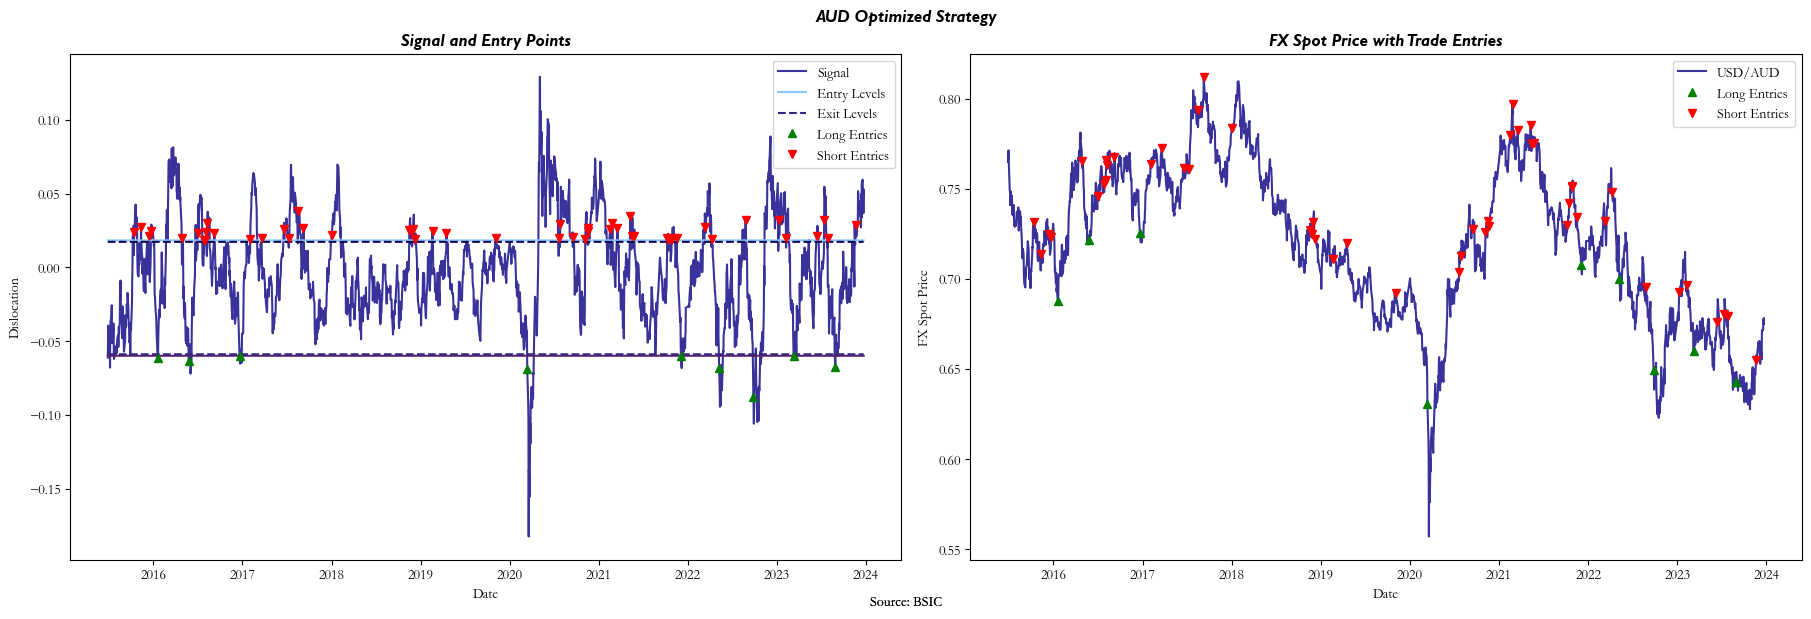

fonts already added so will not add again
fonts already added so will not add again


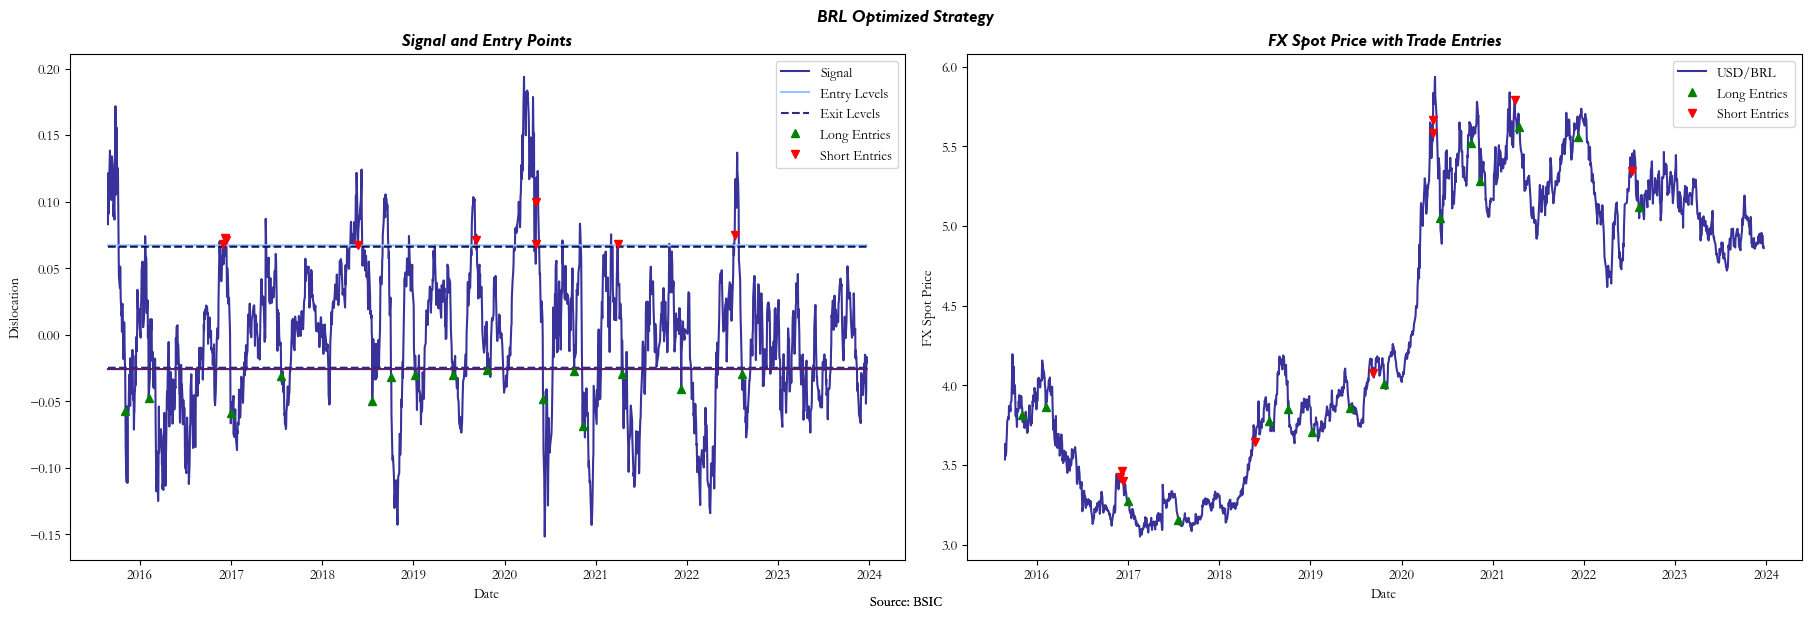

KeyboardInterrupt: 

In [152]:
for currency in fxspot.columns[fxspot.columns != 'USD']:

    zz = EoS_calibrated(currency = currency, period_months = 1, train = 0.5, regression_offset_months = 12,
                 HAC_lags = None, sigmoid_func = np.tanh, N_cap = 101,
                 OLS_dt = 1, transaction_costs = 0.002)

    train_backtest_paper, test_backtest_paper = zz.Backtest_paper()
    test_backtest_paper.plot_entry_points()

fonts already added so will not add again
fonts already added so will not add again


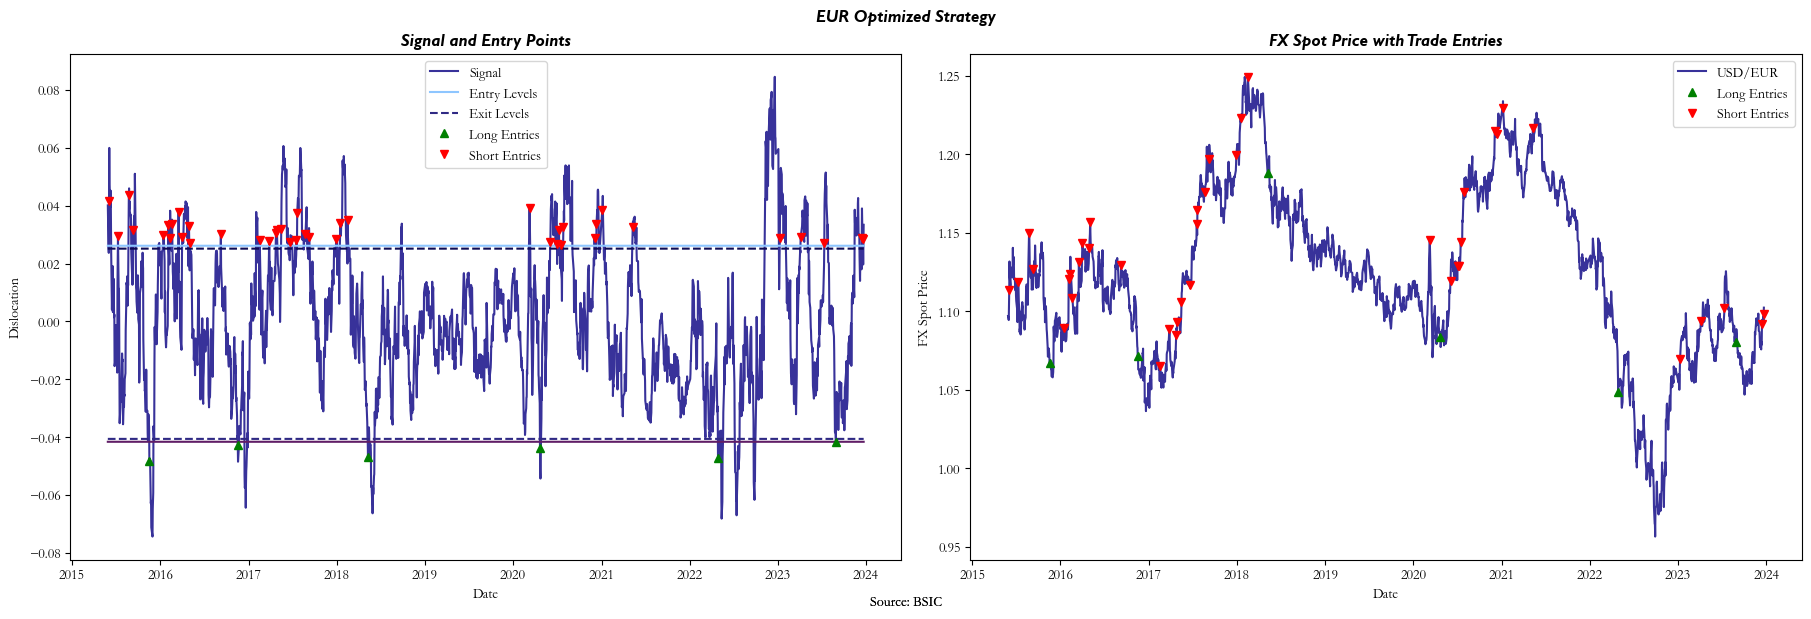

In [22]:
test_backtest_paper.plot_entry_points()

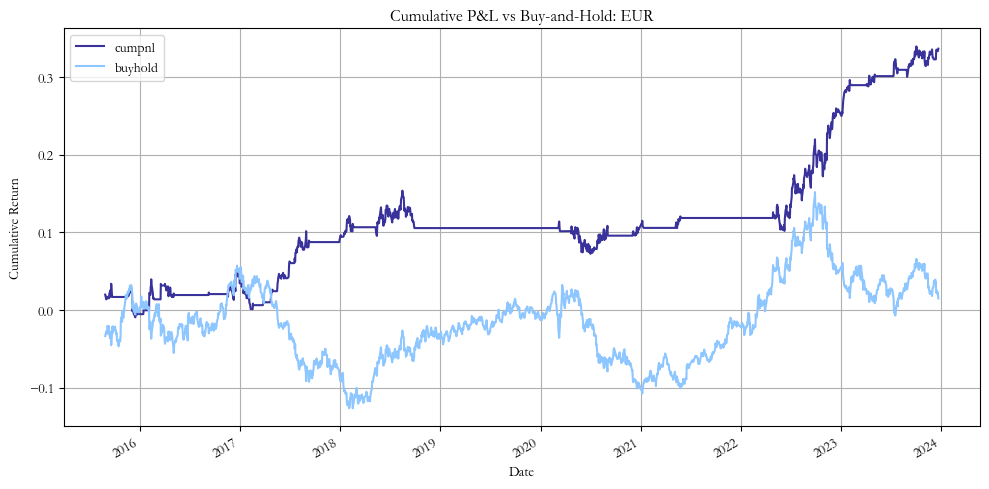

Performance Metrics for EUR Strategy vs Buy-and-Hold:

              Sharpe Ratio  Sortino Ratio    Skew  Hit Ratio  Annualized Volatility  Max Drawdown
Strategy            1.1409         1.1877  1.1278     0.5515                 0.0547        0.0812
Buy and Hold        0.0761         0.1115  0.9942     0.5047                 0.0786        0.1836


In [23]:
pnl = test_backtest_paper.profitandloss()
pnl[['cumpnl', 'buyhold']].plot(
    title=f'Cumulative P&L vs Buy-and-Hold: {currency}',
    ylabel='Cumulative Return',
    xlabel='Date',
    figsize=(10, 5),
    grid=True
)
plt.tight_layout()
plt.show()

test_backtest_paper.display_performance_table()

fonts already added so will not add again


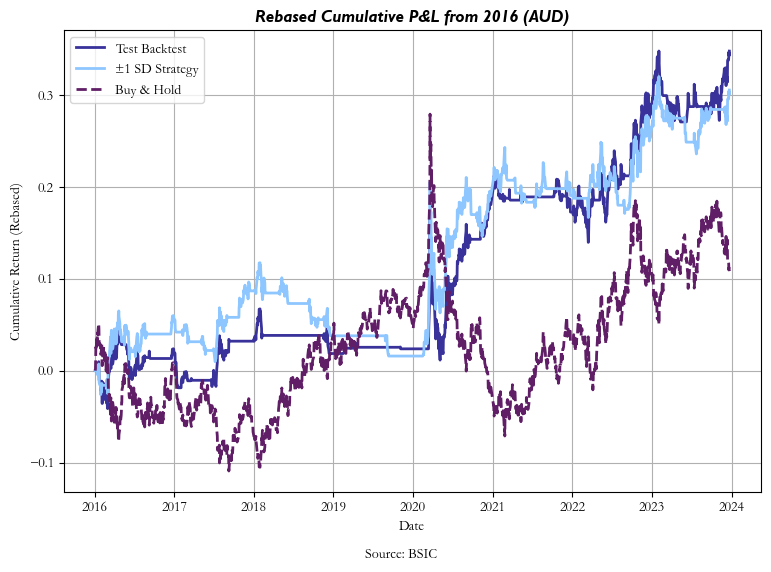

fonts already added so will not add again


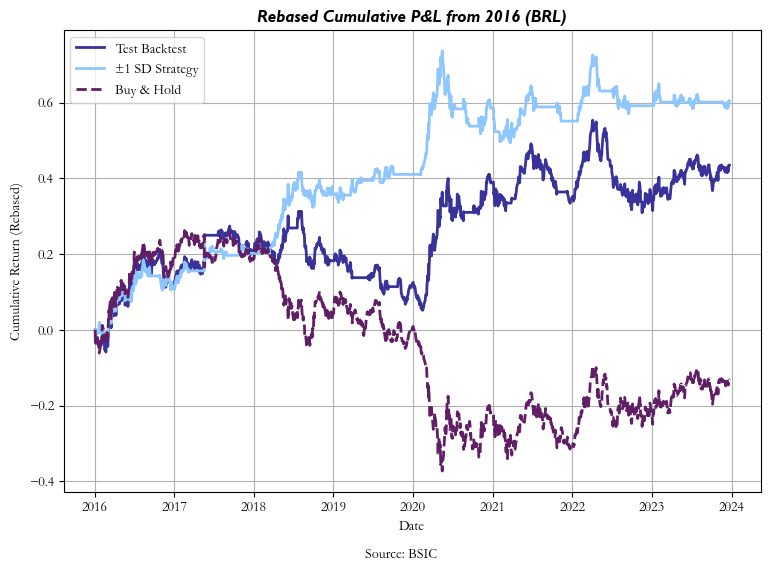

fonts already added so will not add again


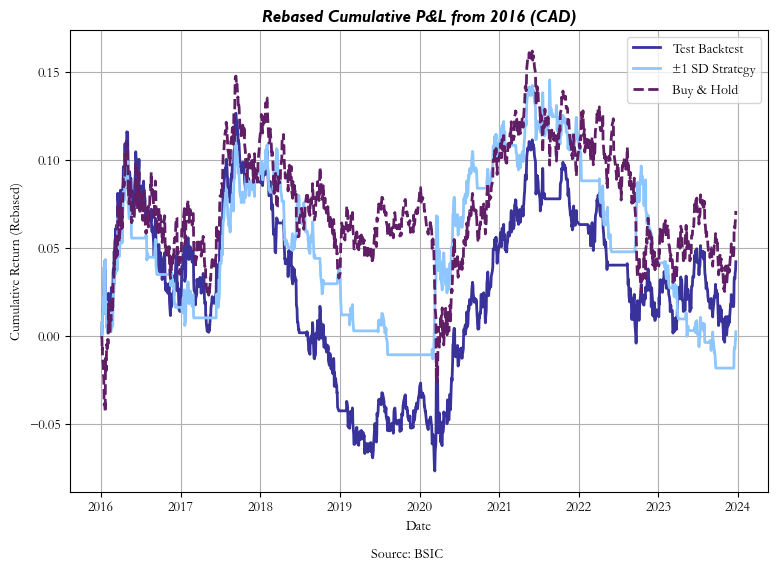

fonts already added so will not add again


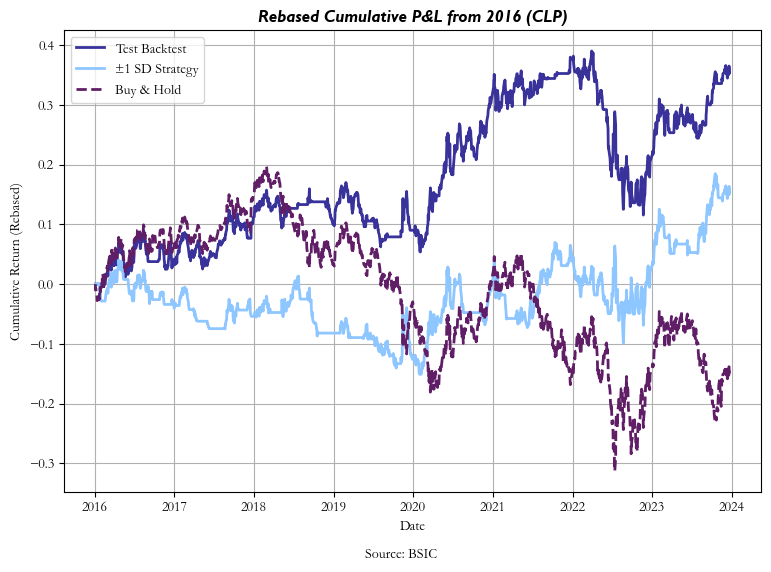

fonts already added so will not add again


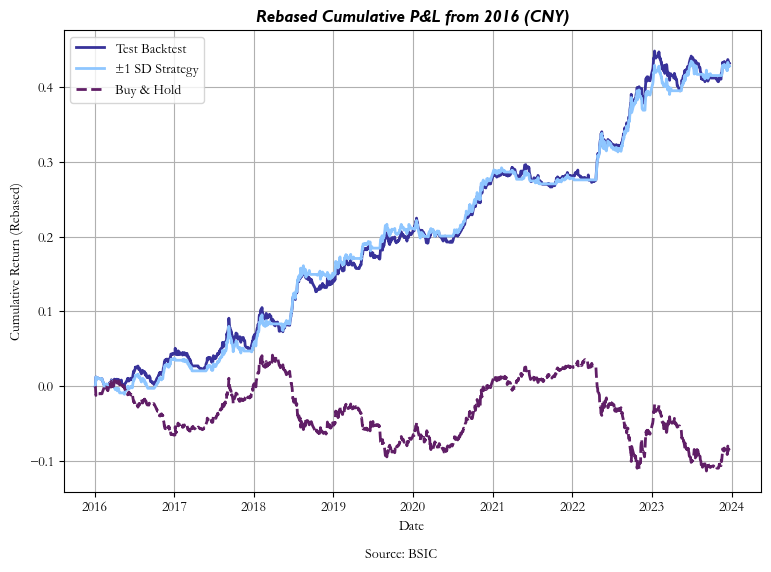

fonts already added so will not add again


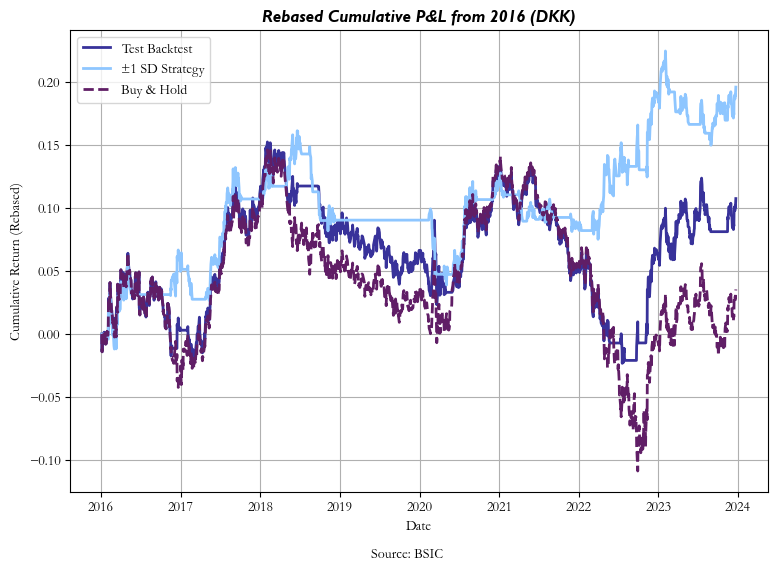

fonts already added so will not add again


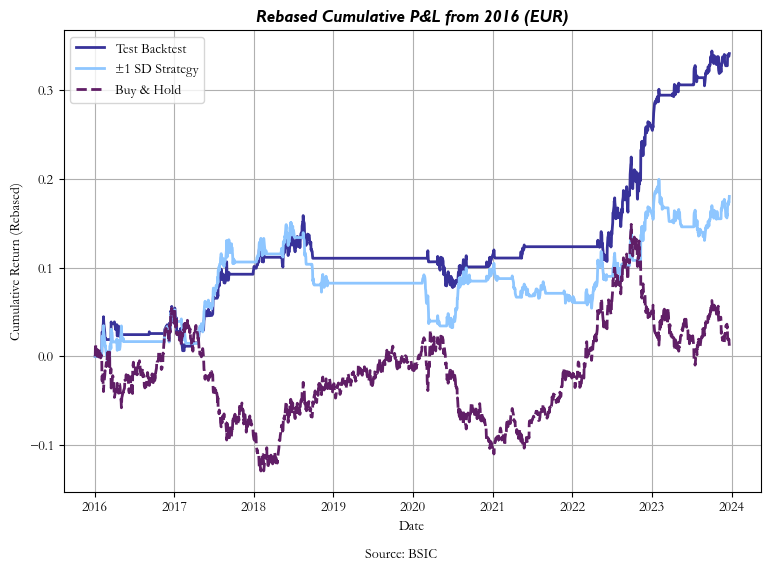

fonts already added so will not add again


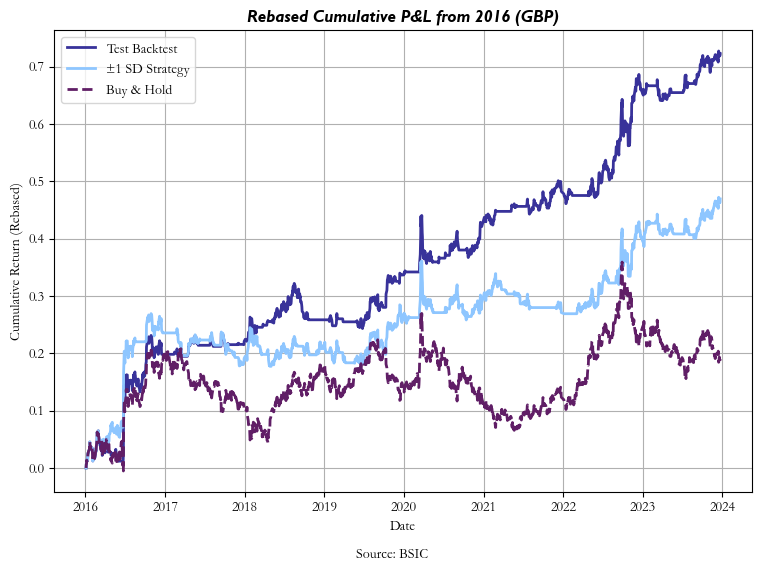

fonts already added so will not add again


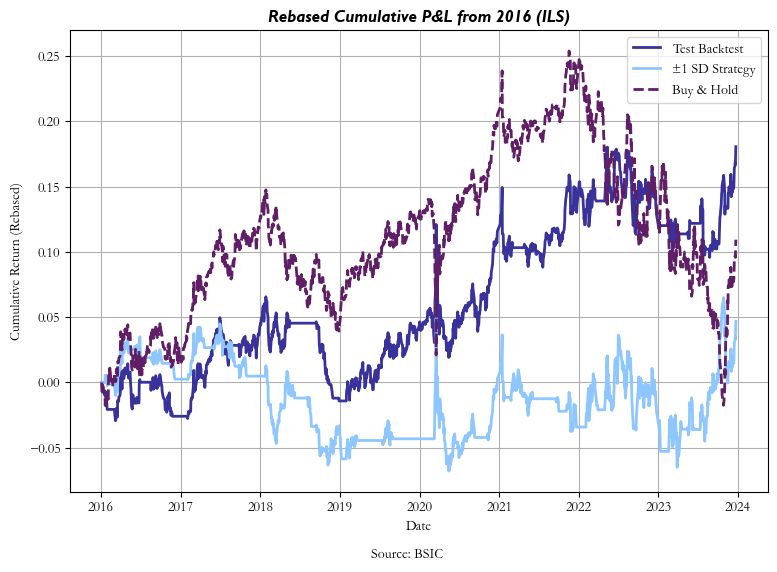

fonts already added so will not add again


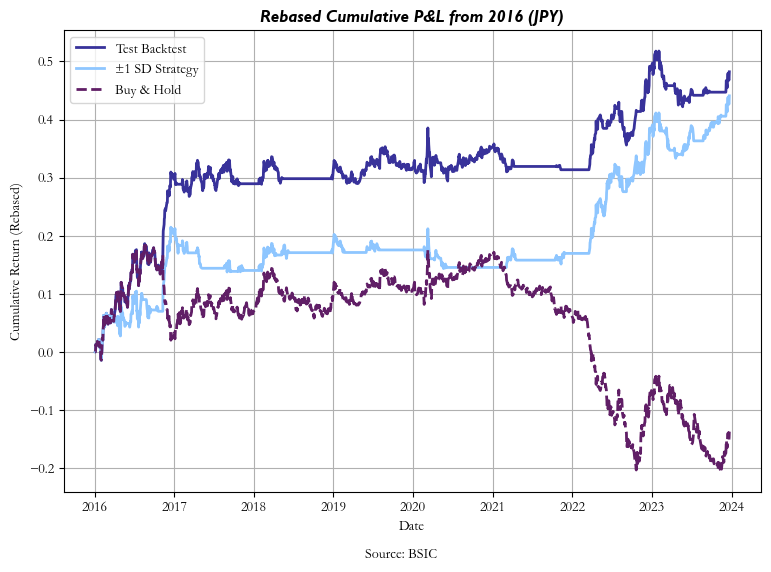

fonts already added so will not add again


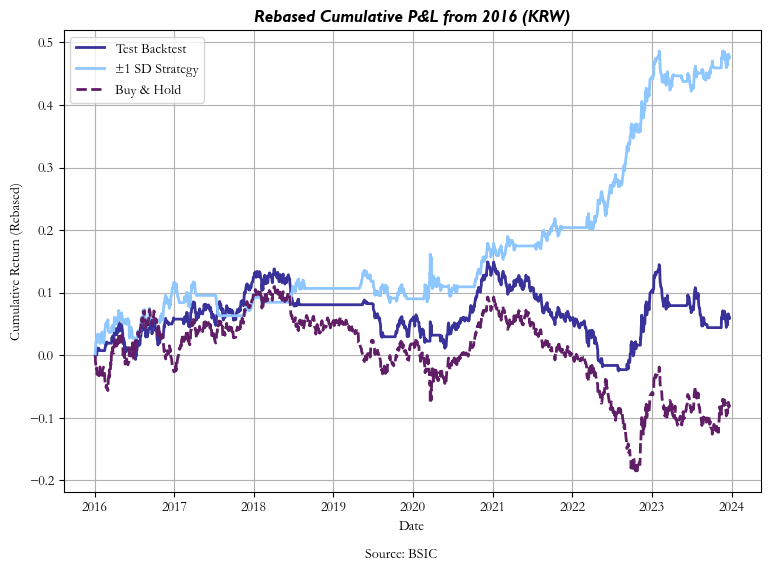

fonts already added so will not add again


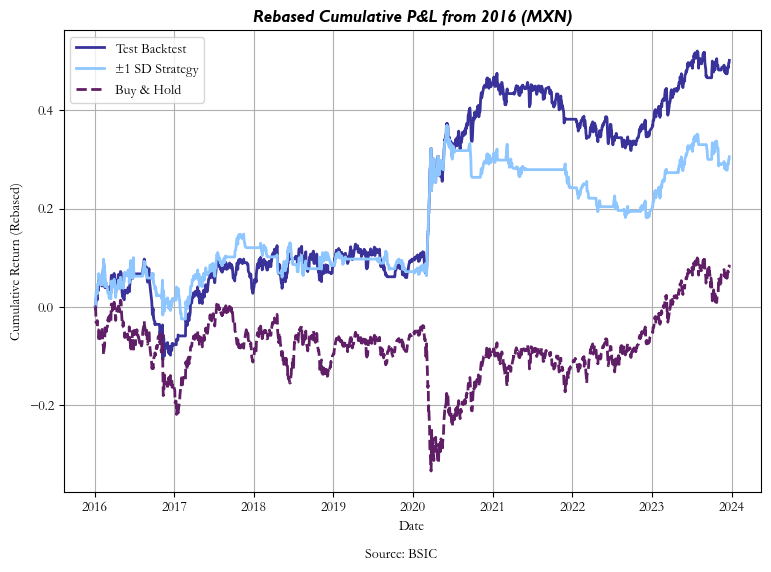

fonts already added so will not add again


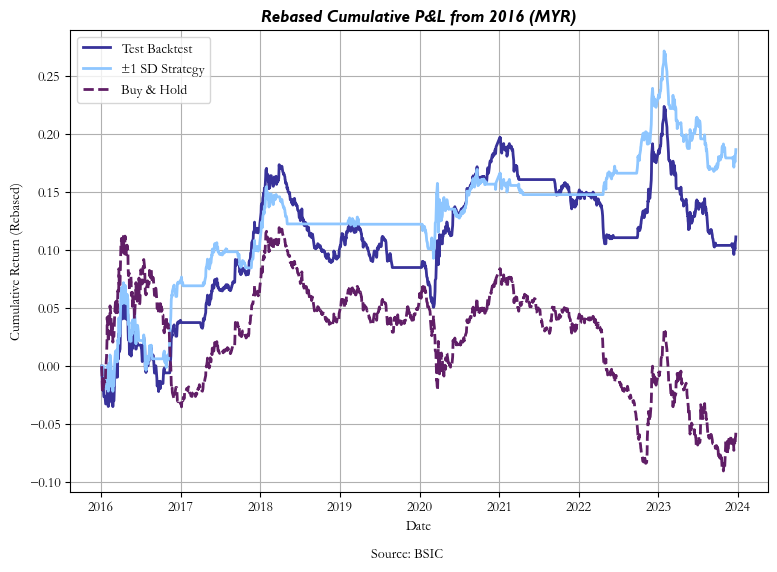

fonts already added so will not add again


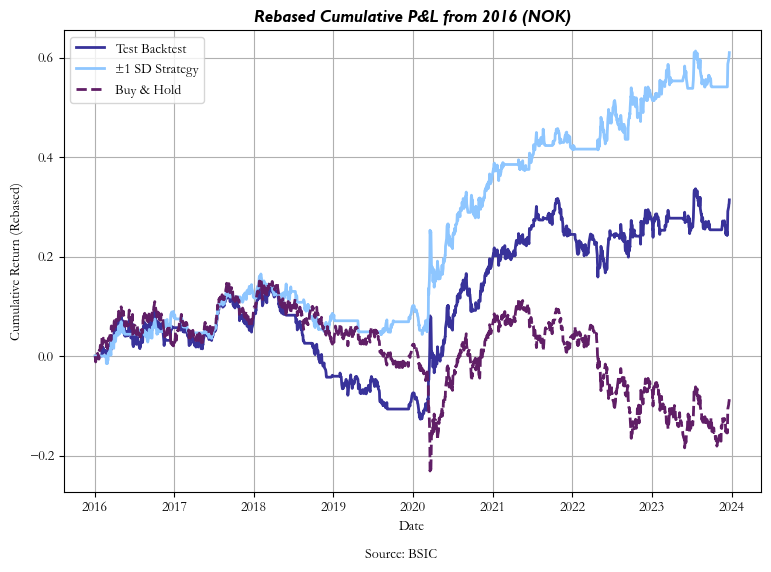

fonts already added so will not add again


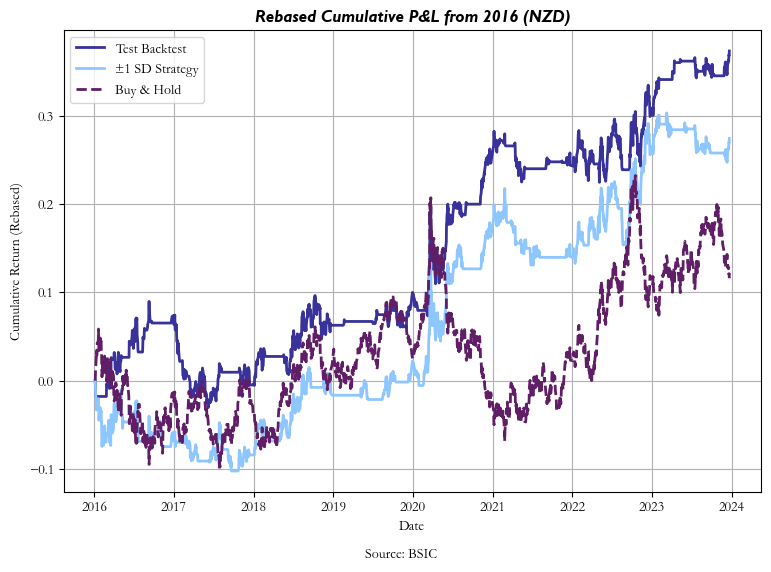

In [123]:
from mpl_bsic import apply_bsic_style, export_figure

for currency in fxspot.columns[fxspot.columns != 'USD']:

    zz = EoS_calibrated(currency = currency, period_months = 1, train = 0.5, regression_offset_months = 12,
                 HAC_lags = None, sigmoid_func = np.tanh, N_cap = 101,
                 OLS_dt = 1, transaction_costs = 0.002)

    train_backtest_paper, test_backtest_paper = zz.Backtest_paper()

    # --- Get PnL from test_backtest_paper ---
    pnl_test = test_backtest_paper.profitandloss()
    pnl_test = pnl_test[pnl_test.index >= '2016-01-01']
    pnl_test['rebased_cumpnl'] = pnl_test['cumpnl'] - pnl_test['cumpnl'].iloc[0]

    # --- Create ±1 SD Strategy on EUR ---
    ccy = currency
    a = linearRegPPP(
        currency=ccy,
        period_months=1,
        HAC_lags=3,
        offset_months=24,
        train=0.5
    )
    full_dict, train_dict, test_dict = a.expanding_window_dislocations()

    bt = Backtest(
        series=full_dict['transformed_dislocations'],
        fxspot_series=full_dict['spot'],
        long_entry=-1,
        long_exit=0,
        short_entry=1,
        short_exit=0,
        currency_name=ccy,
        offset=24,
        transaction_costs=0.002,
        stop_loss=1000
    )

    pnl_sd = bt.profitandloss()
    pnl_sd = pnl_sd[pnl_sd.index >= '2016-01-01']
    pnl_sd['rebased_cumpnl'] = pnl_sd['cumpnl'] - pnl_sd['cumpnl'].iloc[0]

    # --- Buy & Hold strategy (rebased) ---
    pnl_bh = pnl_sd['buyhold']
    pnl_bh = pnl_bh[pnl_bh.index >= '2016-01-01']
    rebased_bh = pnl_bh - pnl_bh.iloc[0]

    # --- BSIC-Styled Overlay Plot ---
    fig, ax = plt.subplots(figsize=(9, 6))

    ax.plot(pnl_test['rebased_cumpnl'], label='Test Backtest', linewidth=2)
    ax.plot(pnl_sd['rebased_cumpnl'], label='±1 SD Strategy', linewidth=2)
    ax.plot(rebased_bh, label='Buy & Hold', linestyle='--', linewidth=2, color='gray')

    ax.set_title(f'Rebased Cumulative P&L from 2016 ({currency})')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Return (Rebased)')
    ax.grid(True)
    ax.legend()

    apply_bsic_style(fig, ax)

    # Save the figure locally as SVG
    export_figure(fig, f"pnl_overlay_{ccy}")
    plt.show()

fonts already added so will not add again


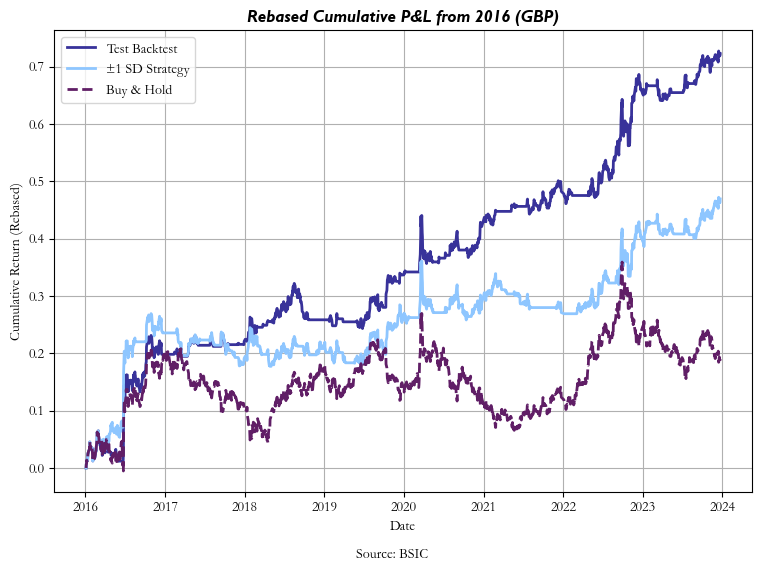

In [24]:
from mpl_bsic import apply_bsic_style, export_figure

currency = 'GBP'

zz = EoS_calibrated(currency = currency, period_months = 1, train = 0.5, regression_offset_months = 12,
                 HAC_lags = None, sigmoid_func = np.tanh, N_cap = 101,
                 OLS_dt = 1, transaction_costs = 0.002)

train_backtest_paper, test_backtest_paper = zz.Backtest_paper()

# --- Get PnL from test_backtest_paper ---
pnl_test = test_backtest_paper.profitandloss()
pnl_test = pnl_test[pnl_test.index >= '2016-01-01']
pnl_test['rebased_cumpnl'] = pnl_test['cumpnl'] - pnl_test['cumpnl'].iloc[0]

# --- Create ±1 SD Strategy on EUR ---
ccy = currency
a = linearRegPPP(
    currency=ccy,
    period_months=1,
    HAC_lags=3,
    offset_months=24,
    train=0.5
)
full_dict, train_dict, test_dict = a.expanding_window_dislocations()

bt = Backtest(
    series=full_dict['transformed_dislocations'],
    fxspot_series=full_dict['spot'],
    long_entry=-1,
    long_exit=0,
    short_entry=1,
    short_exit=0,
    currency_name=ccy,
    offset=24,
    transaction_costs=0.002,
    stop_loss=1000
)

pnl_sd = bt.profitandloss()
pnl_sd = pnl_sd[pnl_sd.index >= '2016-01-01']
pnl_sd['rebased_cumpnl'] = pnl_sd['cumpnl'] - pnl_sd['cumpnl'].iloc[0]

# --- Buy & Hold strategy (rebased) ---
pnl_bh = pnl_sd['buyhold']
pnl_bh = pnl_bh[pnl_bh.index >= '2016-01-01']
rebased_bh = pnl_bh - pnl_bh.iloc[0]

# --- BSIC-Styled Overlay Plot ---
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(pnl_test['rebased_cumpnl'], label='Test Backtest', linewidth=2)
ax.plot(pnl_sd['rebased_cumpnl'], label='±1 SD Strategy', linewidth=2)
ax.plot(rebased_bh, label='Buy & Hold', linestyle='--', linewidth=2, color='gray')

ax.set_title(f'Rebased Cumulative P&L from 2016 ({currency})')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return (Rebased)')
ax.grid(True)
ax.legend()

apply_bsic_style(fig, ax)

# Save the figure locally as SVG
export_figure(fig, f"pnl_overlay_{ccy}")
plt.show()

In [25]:
from mpl_bsic import apply_bsic_style, export_figure

currency = 'EUR'

zz = EoS_calibrated(currency = currency, period_months = 1, train = 0.5, regression_offset_months = 12,
                 HAC_lags = None, sigmoid_func = np.tanh, N_cap = 101,
                 OLS_dt = 1, transaction_costs = 0.002)

train_backtest_paper, test_backtest_paper = zz.Backtest_paper()


a = linearRegPPP(
            currency=currency,
            period_months=1,
            HAC_lags=3,
            offset_months=24,
            train=0.5)
full_dict, train_dict, test_dict = a.expanding_window_dislocations()

bt = Backtest(
        series=full_dict['transformed_dislocations'],
        fxspot_series=full_dict['spot'],
        long_entry=-1,
        long_exit=0,
        short_entry=1,
        short_exit=0,
        currency_name=ccy,
        offset=24,
        transaction_costs=0.002,
        stop_loss=1000)

# --- BSIC-Styled Overlay Plot ---
opt = pd.DataFrame(test_backtest_paper.performance_metrics(start_date="2016-01-01"))['Strategy']
bh = pd.DataFrame(test_backtest_paper.performance_metrics(start_date="2016-01-01"))['Buy and Hold']
one = pd.DataFrame(bt.performance_metrics(start_date="2016-01-01"))['Strategy']

results = pd.concat([opt,one, bh], axis = 1)
results.columns = ['Optimized', '+1/-1  st. dev', 'buy and hold']
print("Currency",currency)
print(results.to_string())


Currency EUR
                       Optimized  +1/-1  st. dev  buy and hold
Sharpe Ratio            1.257777        0.690841      0.019988
Sortino Ratio           1.371428        0.821659      0.029125
Skew                    1.147543        1.051634      0.979858
Hit Ratio               0.556054        0.531616      0.505937
Annualized Volatility   0.053978        0.055063      0.077841
Max Drawdown            0.081245        0.118594      0.183624


In [209]:
from mpl_bsic import apply_bsic_style, export_figure

for currency in fxspot.columns[fxspot.columns != 'USD']:
    zz = EoS_calibrated(currency = currency, period_months = 1, train = 0.5, regression_offset_months = 12,
                 HAC_lags = None, sigmoid_func = np.tanh, N_cap = 101,
                 OLS_dt = 1, transaction_costs = 0.002)

    train_backtest_paper, test_backtest_paper = zz.Backtest_paper()

    a = linearRegPPP(
            currency=currency,
            period_months=1,
            HAC_lags=3,
            offset_months=24,
            train=0.5)
    full_dict, train_dict, test_dict = a.expanding_window_dislocations()

    bt = Backtest(
        series=full_dict['transformed_dislocations'],
        fxspot_series=full_dict['spot'],
        long_entry=-1,
        long_exit=0,
        short_entry=1,
        short_exit=0,
        currency_name=currency,
        offset=24,
        transaction_costs=0.002,
        stop_loss=1000)

# --- BSIC-Styled Overlay Plot ---
    opt = pd.DataFrame(test_backtest_paper.performance_metrics(start_date="2016-01-01"))['Strategy']
    bh = pd.DataFrame(test_backtest_paper.performance_metrics(start_date="2016-01-01"))['Buy and Hold']
    one = pd.DataFrame(bt.performance_metrics(start_date="2016-01-01"))['Strategy']

    results = pd.concat([opt,one, bh], axis = 1)
    results.columns = ['Optimized', '+1/-1  st. dev', 'buy and hold']
    results.to_excel(f'{currency}_res.xlsx')


In [200]:
opt = pd.DataFrame(test_backtest_paper.performance_metrics(start_date="2016-01-01"))['Strategy']
bh = pd.DataFrame(test_backtest_paper.performance_metrics(start_date="2016-01-01"))['Buy and Hold']
one = pd.DataFrame(bt.performance_metrics(start_date="2016-01-01"))['Strategy']

results = pd.concat([opt,one, bh], axis = 1)
results.columns = ['Optimized', '+1/-1  st. dev', 'buy and hold']
results.to_excel(f'{currency}_res.xlsx')

In [108]:
print("\n OPTIMAL BANDS BACKTEST PERFORMANCE")
test_backtest_paper.display_performance_table(start_date="2016-01-01")

print("\n +-1 SD STRATEGY PERFORMANCE")
bt.display_performance_table(start_date="2016-01-01")


 OPTIMAL BANDS BACKTEST PERFORMANCE
Performance Metrics for NZD Strategy vs Buy-and-Hold:

              Sharpe Ratio  Sortino Ratio    Skew  Hit Ratio  Annualized Volatility  Max Drawdown
Strategy            1.0051         1.1378  1.0436     0.5481                 0.0826        0.1203
Buy and Hold        0.1398         0.2273  1.0072     0.5040                 0.1107        0.2757

 +-1 SD STRATEGY PERFORMANCE
Performance Metrics for NZD Strategy vs Buy-and-Hold:

              Sharpe Ratio  Sortino Ratio    Skew  Hit Ratio  Annualized Volatility  Max Drawdown
Strategy            0.6278         0.7476  0.9774     0.5408                 0.0857        0.1023
Buy and Hold        0.1398         0.2273  1.0072     0.5040                 0.1107        0.2757


### The parametric approach - fitting an OU process

$$ dX_t = \kappa (\theta - X_t) dt + \sigma dW_t $$

In [ ]:
currency = 'AUD'

a = linearRegPPP(currency = currency, period_months = 1, train = 0.5)
train_devs_daily, test_devs_daily = a.deviations()
fxspot_train, fxspot_test = a.fxspot()

path = train_devs_daily

1. Least squares calibration
<div align = 'center'>
    <img src = "attachment:3268dc16-cc73-4ac7-9b12-18f181ee2367.png" width = "400">
</div>
<div align = 'left'>
    <img src = "attachment:01511d29-7632-42bc-a554-e102f856cb00.png" width = "500">
</div>
<div align = 'center'>
    <img src = "attachment:3ce94cbb-d323-46e9-a2a2-8b308e0e1b02.png" width = "400">
</div>

2. Maxikappam likelihood

Idea: take the following likelihood function, derived since $X_t$ has the Markov property and it is normally distributed.
<div align = 'center'>
    <img src = "attachment:65c4df18-26ab-4ffd-942e-c070723d1fb0.png" width = "400">
</div>

In [ ]:
kappa = -np.log(m.params['X'])
sigma = np.std(m.resid, ddof = 2) * np.sqrt(2*kappa/(1-m.params['X']**2))
theta = 1/(1-np.exp(kappa))
print(kappa, theta, sigma)
print(np.mean(path))

In [ ]:
regr_df = pd.DataFrame({'Y': path.shift(-1), 'X': path}).dropna()
m = smf.OLS(regr_df['Y'], smf.add_constant(regr_df['X'])).fit()

In [ ]:
XX = regr_df['X']
YY = regr_df['Y']
N = len(XX)
dt = 1

Sx = np.sum(XX)
Sy = np.sum(YY)
Sxx = XX @ XX
Sxy = XX @ YY
Syy = YY @ YY

theta_mle = (Sy * Sxx - Sx * Sxy) / (N * (Sxx - Sxy) - (Sx**2 - Sx * Sy))
kappa_mle = -(1 / dt) * np.log(
    (Sxy - theta_mle * Sx - theta_mle * Sy + N * theta_mle**2) / (Sxx - 2 * theta_mle * Sx + N * theta_mle**2)
)
sigma2_hat = (
    Syy
    - 2 * np.exp(-kappa_mle * dt) * Sxy
    + np.exp(-2 * kappa_mle * dt) * Sxx
    - 2 * theta_mle * (1 - np.exp(-kappa_mle * dt)) * (Sy - np.exp(-kappa_mle * dt) * Sx)
    + N * theta_mle**2 * (1 - np.exp(-kappa_mle * dt)) ** 2
) / N
sigma_mle = np.sqrt(sigma2_hat * 2 * kappa_mle / (1 - np.exp(-2 * kappa_mle * dt)))

print(theta_mle, kappa_mle, sigma_mle)

In [ ]:
def sikappalate_ou_process(kappa, theta, sigma, X_0, dt = 1):
    N = len(path)

    # Initialize the array to store the path
    X = np.zeros(N)

    # Set the initial value
    X[0] = X_0

    # Sikappalate the process
    for t in range(1, N):
        dW = np.random.normal(0, np.sqrt(dt))  # Increment of Wiener process (Gaussian noise)
        X[t] = X[t-1] + kappa * (theta - X[t-1]) * dt + sigma * dW

    return pd.Series(X, index = path.index)

In [ ]:
plt.plot(path)
store_path = []
for i in range(0,100):
    sim_path = sikappalate_ou_process(kappa_mle, theta_mle, sigma_mle, X_0 = path[0])
    store_path.append(sim_path)
    plt.plot(sim_path)

### The nonparametric approach


Idea: a nonparametric approach to the traditional drift/diffusion setup:
$$ dX_t = f(X_t) dt + g(X_t) dW_t $$

1. Approach 1.
    - Split data in 2 folds.
    - Determine N buckets.
    - Fit a spline to the estimated median drift/diffusion of each bucket in the training set.
    - Measure errors in the test set, and choose the N that minimizes out of sample error.
    - Question: how do we weight errors?
2. Approach 2.
    - Split data into K folds.
    - In each fold, split the data within N buckets.
    - Compute median drift for each bucket within each fold.
    - Observe the distribution of median drifts for each bucket across folds and fit a spline to its average?
    - Question: do you determine bucket limits globally or on a fold-by-fold basis?
3. Approach 3.
    - Split data into K folds.
    - In each fold, split the data within N buckets.
    - Compute median drift for each bucket within each fold.
    - When sikappalating a path of model dislocations, for each timestep $t$, determine the bucket $X_t$ belongs to, and pick $f(X_t)$ and $g(X_t)$ randomly from the empirical values belonging to that bucket.

### Approach 1

In [ ]:
kappa_sample_train = kappa_calibration_train.groupby('x bin', observed = True)['dx'].median().values
kappa_sample_test = kappa_calibration_test.groupby('x bin', observed = True)['dx'].median().values

kappa_index = np.arange(1, len(kappa_sample_train) + 1,1)
kappa_index_smooth = np.linspace(1, len(kappa_sample_train)+1,100)

cs_train = CubicSpline(kappa_index, kappa_sample_train)

kappa_fitted_train = cs_train(kappa_index_smooth)
kappa_fitted_test = cs_train(kappa_index_smooth)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

ax[0].scatter(kappa_index, kappa_sample_train)
ax[0].plot(kappa_index_smooth, kappa_fitted_train)

ax[1].scatter(kappa_index, kappa_sample_test, color = 'red')
ax[1].plot(kappa_index_smooth, kappa_fitted_test, color = 'red')

In [ ]:
a = linearRegPPP(currency = 'GBP', period_months = 1, train = 0.5)
train_devs_daily, test_devs_daily = a.deviations()
PRECISION = 0.2
mse_errs = []
mae_errs = []

for N in range(2,10):

    alt_train = np.tanh(train_devs_daily) - np.mean(np.tanh(train_devs_daily))
    alt_test = np.tanh(test_devs_daily) - np.mean(np.tanh(test_devs_daily))

    kappa_calibration_train = pd.DataFrame({'x':alt_train, 'dx':alt_train.diff()}).dropna()

    kappa_calibration_train['x bin'] = pd.cut(kappa_calibration_train['x'], bins = np.linspace(
        kappa_calibration_train.describe()['x']['min'],
        kappa_calibration_train.describe()['x']['max'],N))

    kappa_calibration_test = pd.DataFrame({'x':alt_test, 'dx':alt_test.diff()}).dropna()

    kappa_calibration_test['x bin'] = pd.cut(kappa_calibration_test['x'], bins = np.linspace(
        kappa_calibration_test.describe()['x']['min'],
        kappa_calibration_test.describe()['x']['max'],N))

    kappa_sample_train = kappa_calibration_train.groupby('x bin', observed = True)['dx'].median().values
    kappa_sample_test = kappa_calibration_test.groupby('x bin', observed = True)['dx'].median().values

    kappa_test_intmin = kappa_sample_test - PRECISION*kappa_calibration_test.groupby('x bin', observed = True)['dx'].std().values
    kappa_test_intmax = kappa_sample_test + PRECISION*kappa_calibration_test.groupby('x bin', observed = True)['dx'].std().values

    kappa_index = np.arange(1, len(kappa_sample_train) + 1,1)
    kappa_index_smooth = np.linspace(1, len(kappa_sample_train)+1,100)
    cs_train = CubicSpline(kappa_index, kappa_sample_train)

    kappa_fitted_train = cs_train(kappa_index_smooth)
    kappa_fitted_test = cs_train(kappa_index_smooth)

    mse_errs.append(sum((cs_train(kappa_index) - kappa_sample_test)**2)/N)
    mae_errs.append(sum(abs(cs_train(kappa_index) - kappa_sample_test))/N)

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

ax[0].scatter(kappa_index, kappa_sample_train)
ax[0].plot(kappa_index_smooth, kappa_fitted_train)

ax[1].scatter(kappa_index, kappa_sample_test, color = 'red')
ax[1].plot(kappa_index_smooth, kappa_fitted_test, color = 'red')
ax[1].fill_between(kappa_index, kappa_test_intmin, kappa_test_intmax, color = 'grey', alpha = 0.1)

In [ ]:
kappa_sample_train = kappa_calibration_train.groupby('x bin', observed = True)['dx'].median().values

kappa_train_intmin = kappa_sample_train - kappa_calibration_train.groupby('x bin', observed = True)['dx'].std().values
kappa_train_intmax = kappa_sample_train + kappa_calibration_train.groupby('x bin', observed = True)['dx'].std().values

# pd.DataFrame({'x':kappa_sample_train,'xmin':kappa_train_intmin, 'xmax':kappa_train_intmax})
kappa_index = np.arange(1, len(kappa_sample_train) + 1,1)
plt.plot(kappa_sample_train)
plt.fill_between(kappa_index, kappa_train_intmin, kappa_train_intmax, color = 'lightblue', alpha = 0.2)

### Approach 2 and 3 setup

In [ ]:
class driftCalibration():                       # this class only needs a data series as input
    def __init__(self, series, buckets, folds):
        self.series = series.dropna()
        self.buckets = buckets + 1
        self.folds = folds            # ignore these +1 and +2 they're just to make the code work, i'll fix them later

    def define_buckets(self):
        bin_limits = np.linspace(self.series.min(), self.series.max(), self.buckets)
        return bin_limits

    def median_drift(self):
        drift_df = pd.DataFrame({'x':self.series, 'dx':self.series.diff()}).dropna()
        drift_df['x bin'] = pd.cut(drift_df['x'],
                                   bins = np.linspace(drift_df.describe()['x']['min'],
                                                      drift_df.describe()['x']['max'],
                                                     self.buckets))
        median_drifts = drift_df.groupby('x bin', observed = True)['dx'].median().values
        return median_drifts

    def fold_split(self):
        T = len(self.series)
        fold_indexes = self.series.index[::int(np.floor(T/self.folds))]
        data_by_fold = {i: np.nan for i in range(1, self.folds+1)}
        for k in range(1, self.folds+1):
            fold_beg = fold_indexes[k-1] + relativedelta(days = 1)
            fold_end = fold_indexes[k]

            fold_data = self.series[fold_beg:fold_end]
            data_by_fold[k] = fold_data
        return data_by_fold

    def median_drift_by_fold(self):
        drifts_dict = dict()
        data_by_fold = self.fold_split()
        bin_limits = np.linspace(self.series.min(), self.series.max(), self.buckets)

        for fold in data_by_fold.keys():
            fold_data = data_by_fold[fold]
            drift_df = pd.DataFrame({'x':fold_data, 'dx': fold_data.diff()}).dropna()


            drift_df['x bin'] = pd.cut(drift_df['x'], bin_limits)
            bin_categories = pd.cut(pd.Series(bin_limits[:-1] + np.diff(bin_limits)/2), bins=bin_limits).cat.categories

            median_drifts = drift_df.groupby('x bin', observed = True)['dx'].median().reindex(bin_categories).values
            drifts_dict[fold] = median_drifts

        return drifts_dict

    def drifts_by_bucket(self):
        drifts_dict = self.median_drift_by_fold()
        buckets_distr = [[] for n in range(0, self.buckets)]

        for bucket in range(0, self.buckets):
            for fold in drifts_dict.keys():
                drift_value = drifts_dict[fold][bucket-1]
                buckets_distr[bucket].append(drift_value)

        return buckets_distr

    def provide_random_param(self, X):
        series_buckets = self.define_buckets()
        target_bucket = np.digitize(X, series_buckets) - 1
        bucket_distr = self.drifts_by_bucket()[target_bucket]
        random_param = np.random.choice(bucket_distr, size = 1, replace = True)
        while np.isnan(random_param):
            random_param = np.random.choice(bucket_distr, size = 1, replace = True)
        return random_param

    def plot_drifts_by_bucket(self):

        buckets_distr = self.drifts_by_bucket()

        xaxis = []
        yaxis = []

        for i, samples in enumerate(buckets_distr):
            xaxis.extend([i+1] * len(samples))
            yaxis.extend(samples)

        plt.scatter(xaxis, yaxis, alpha=0.6)
        plt.xlabel("Bucket")
        plt.ylabel("Observations of drift median")
        plt.title("Sample Values per Indicator")
        plt.xticks(range(len(buckets_distr)+1))
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.show()

In [ ]:
class volCalibration():                       # this class only needs a data series as input
    def __init__(self, series, buckets, folds):
        self.series = series.dropna()
        self.buckets = buckets + 1
        self.folds = folds            # ignore these +1 and +2 they're just to make the code work, i'll fix them later

    def define_buckets(self):
        bin_limits = np.linspace(self.series.min(), self.series.max(), self.buckets)
        return bin_limits

    def median_vol(self):
        vol_df = pd.DataFrame({'x':self.series, 'dx':self.series.diff()}).dropna()
        vol_df['x bin'] = pd.cut(vol_df['x'],
                                   bins = np.linspace(vol_df.describe()['x']['min'],
                                                      vol_df.describe()['x']['max'],
                                                     self.buckets))
        median_vols = vol_df.groupby('x bin', observed = True)['dx'].std().values
        return median_vols

    def fold_split(self):
        T = len(self.series)
        fold_indexes = self.series.index[::int(np.floor(T/self.folds))]
        data_by_fold = {i: np.nan for i in range(1, self.folds+1)}
        for k in range(1, self.folds+1):
            fold_beg = fold_indexes[k-1] + relativedelta(days = 1)
            fold_end = fold_indexes[k]

            fold_data = self.series[fold_beg:fold_end]
            data_by_fold[k] = fold_data
        return data_by_fold

    def median_vol_by_fold(self):
        vols_dict = dict()
        data_by_fold = self.fold_split()
        bin_limits = np.linspace(self.series.min(), self.series.max(), self.buckets)


        for fold in data_by_fold.keys():
            fold_data = data_by_fold[fold]
            vol_df = pd.DataFrame({'x':fold_data, 'dx': fold_data.diff()}).dropna()

            vol_df['x bin'] = pd.cut(vol_df['x'], bin_limits)
            bin_categories = pd.cut(pd.Series(bin_limits[:-1] + np.diff(bin_limits)/2), bins=bin_limits).cat.categories

            median_vols = vol_df.groupby('x bin', observed = True)['dx'].std().reindex(bin_categories).values
            vols_dict[fold] = median_vols

        return vols_dict

    def vols_by_bucket(self):
        vols_dict = self.median_vol_by_fold()
        buckets_distr = [[] for n in range(0, self.buckets)]

        for bucket in range(0, self.buckets):
            for fold in vols_dict.keys():
                vol_value = vols_dict[fold][bucket-1]
                buckets_distr[bucket].append(vol_value)

        return buckets_distr

    def provide_random_param(self, X):
        series_buckets = self.define_buckets()
        target_bucket = np.digitize(X, series_buckets) - 1
        bucket_distr = self.vols_by_bucket()[target_bucket]
        random_param = np.random.choice(bucket_distr, size = 1, replace = True)
        while np.isnan(random_param):
            random_param = np.random.choice(bucket_distr, size = 1, replace = True)
        return random_param

    def plot_vols_by_bucket(self):
        buckets_distr = self.vols_by_bucket()

        xaxis = []
        yaxis = []

        for i, samples in enumerate(buckets_distr):
            xaxis.extend([i+1] * len(samples))
            yaxis.extend(samples)

        plt.scatter(xaxis, yaxis, alpha=0.6)
        plt.xlabel("Bucket")
        plt.ylabel("Observations of jump std")
        plt.title("Sample Values per Indicator")
        plt.xticks(range(len(buckets_distr)+1))
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.show()

In [ ]:
a = linearRegPPP(currency = 'CLP', period_months = 1, train = 0.5)
train_devs_daily, test_devs_daily = a.deviations()

N = 8
K = 50

alt_train = np.tanh(train_devs_daily) - np.mean(np.tanh(train_devs_daily))
alt_test = np.tanh(test_devs_daily) - np.mean(np.tanh(test_devs_daily))

dd = driftCalibration(alt_test, buckets = N, folds = K)
vv = volCalibration(alt_test, buckets = N, folds = K)

#dd.plot_drifts_by_bucket()
#vv.plot_vols_by_bucket()

dd.plot_drifts_by_bucket()
vv.plot_vols_by_bucket()

### Implementing approach 3

In [ ]:
a = linearRegPPP(currency = 'MYR', period_months = 1, train = 0.5)
train_devs_daily, test_devs_daily = a.deviations()

N = 8
K = 50

alt_train = np.tanh(train_devs_daily) - np.mean(np.tanh(train_devs_daily))
alt_test = np.tanh(test_devs_daily) - np.mean(np.tanh(test_devs_daily))

dd = driftCalibration(alt_train, buckets = N, folds = K)
vv = volCalibration(alt_train, buckets = N, folds = K)

In [ ]:
drift_buckets = dd.define_buckets()
vol_buckets = vv.define_buckets()

drift_midpoints = (dd.define_buckets()[:-1] + dd.define_buckets()[1:])/ 2
vol_midpoints = (vv.define_buckets()[:-1] + vv.define_buckets()[1:])/ 2

path_drifts = []
path_vols = []

for midpoint in drift_midpoints:
    path_drifts.append(dd.provide_random_param(midpoint))

for midpoint in drift_midpoints:
    path_vols.append(vv.provide_random_param(midpoint))

In [ ]:
timeindex = range(0,len(alt_train))
N = 100
path_list = []
shocks_list = []
drift_bucket_tracker = []
vol_bucket_tracker = []

for q in range(N):
    X_0 = alt_train[0]
    path = np.array([X_0])
    shocks = []
    drift_bucket_series = []
    vol_bucket_series = []

    for t in timeindex:
        X_t = path[-1]

        target_drift_bucket = np.digitize(X_t, drift_midpoints) - 1
        target_vol_bucket = np.digitize(X_t, vol_midpoints) - 1

        drift_bucket_series.append(target_drift_bucket)
        vol_bucket_series.append(target_vol_bucket)

        drift = path_drifts[target_drift_bucket]
        vol = path_drifts[target_vol_bucket]
        shock = np.random.randn(1)

        dX_t = drift + shock * vol
        X_t = X_t + dX_t
        path = np.append(path, X_t)
        shocks.append(shock)

    path_list.append(path)
    shocks_list.append(shocks)
    drift_bucket_tracker.append(drift_bucket_series)
    vol_bucket_tracker.append(vol_bucket_series)

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
for q in range(0, N):
    ax[0].plot(drift_bucket_tracker[q])
    ax[1].plot(vol_bucket_tracker[q])

In [ ]:
for i in path_list:
    plt.plot(i)

In [ ]:
for i in shocks_list:
    plt.plot(i)